# Import Packages, Functions, and Dataset
First we import the packages to be used for the assignment

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as k
from keras import regularizers
import time

Set the random seed for consistent results each time we rerun the code

In [37]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

### Define the Functions to be Used

In [38]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

# https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")
    
# to convert an index n, 0<= n < 784
def pair(n,size):
    x = n//size 
    y = n%size
    return x,y

### Load the MNIST Dataset
The MNIST dataset contains 70,000 total images of handwritten numbers from 0-9. The dataset is split between 60,000 training images and 10,000 test images.

In [39]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# EDA
### Find frequency of each label in training and test sets

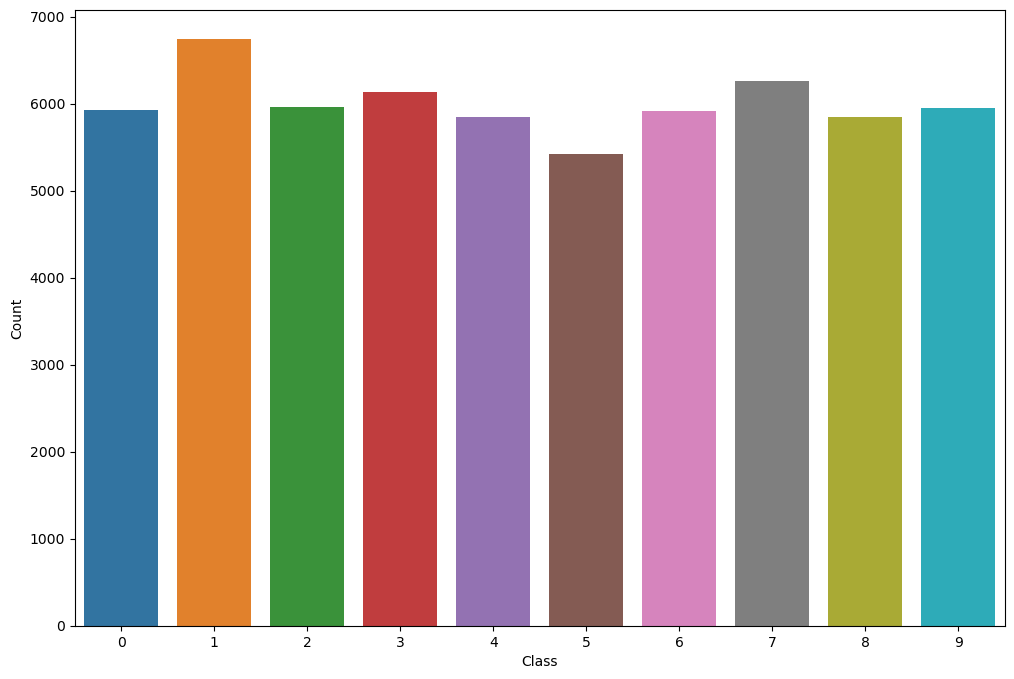

In [40]:
# Training Data
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(train_labels).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

In [41]:
Counter(train_labels).most_common()

[(1, 6742),
 (7, 6265),
 (3, 6131),
 (2, 5958),
 (9, 5949),
 (0, 5923),
 (6, 5918),
 (8, 5851),
 (4, 5842),
 (5, 5421)]

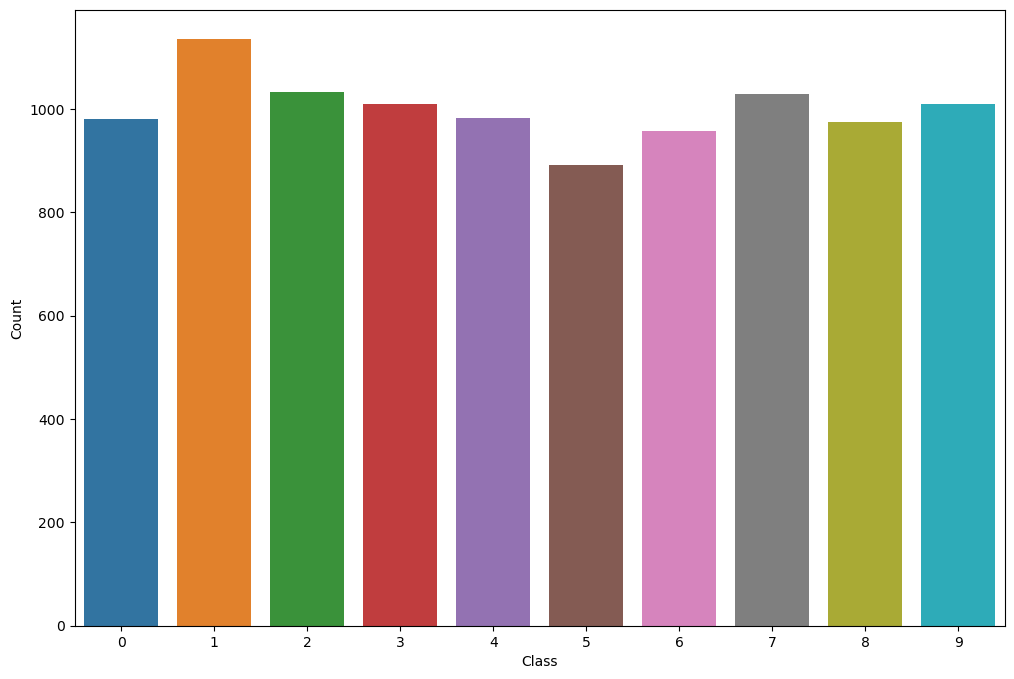

In [42]:
# Test Data
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(test_labels).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

In [43]:
Counter(test_labels).most_common()

[(1, 1135),
 (2, 1032),
 (7, 1028),
 (3, 1010),
 (9, 1009),
 (4, 982),
 (0, 980),
 (8, 974),
 (6, 958),
 (5, 892)]

### Plot sample images with their labels

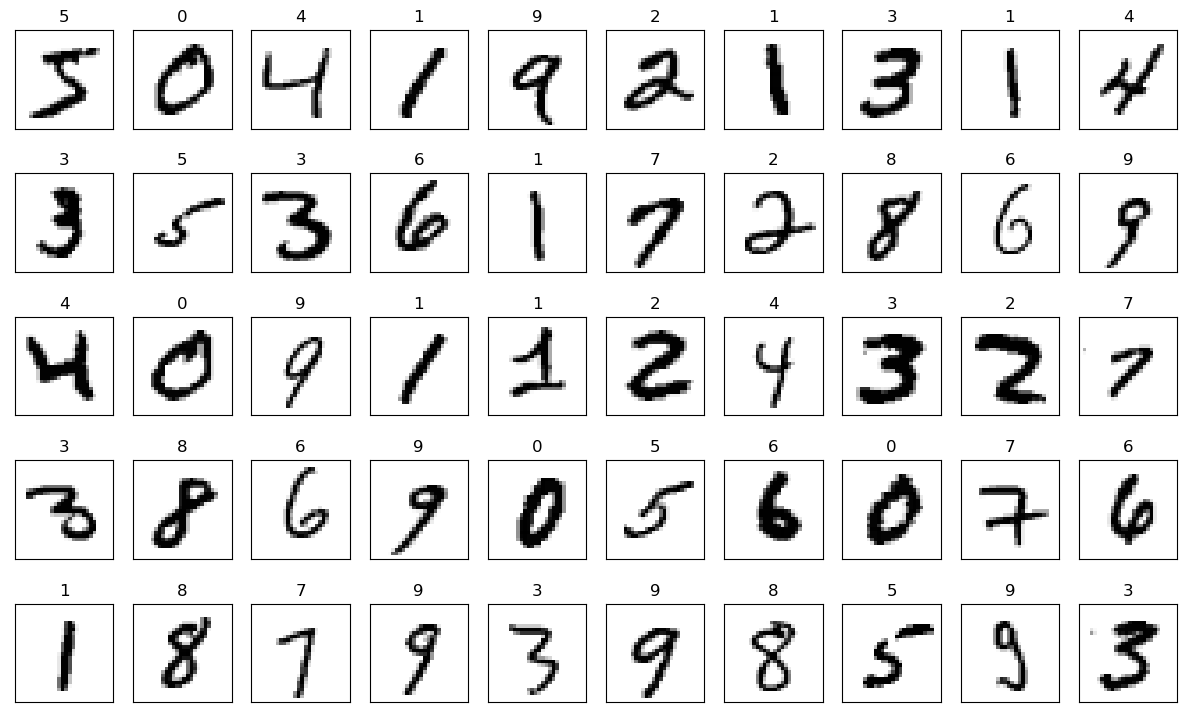

In [44]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(train_labels[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i].reshape(28,28), cmap='binary')

# Prepare the Data
- The data is reshaped from 2D images of shape (28, 28) to 1D vector arrays of shape (784,)
- The images are initially pixel values from 0-255, with 0 = white and 255 = black. These are divided by 255 to normalize the image data
- The labels are initially a single number from 0-9. We use one-hot encoding to convert the labels to vectors of shape (10,)

In [45]:
print("Format of train images before divide by 255")
np.set_printoptions(linewidth=np.inf)
print("{}".format(train_images[235]))

Format of train images before divide by 255
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  81 105 106 140 254 254 254 255 254  76   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 198 243 253 254 253 253 253 253 253 253 238  49   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 239 253 253 254 249 140  89 132 240 253 253 156   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 239 232 133 134 102   0   0   0  31 253 253 208   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   

In [46]:
# reshape the images
train_images = np.reshape(train_images, (60000, 784))
test_images = np.reshape(test_images, (10000, 784))

# normalize images
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# One-hot encoding for labels
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [47]:
print("First ten rows of one-hot train labels:\n {}".format(train_labels[0:10,]))

First ten rows of one-hot train labels:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


### Validate the Data

In [48]:
val_images, train_images = train_images[:5000], train_images[5000:]
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

___
# Experiment 1
Here the dense neural network will start with 784 input nodes, a single hidden layer with 1 neuron, and 10 output nodes that correspond to the 10 digits.
___
### Build the Model

In [49]:
model = Sequential([
    Dense(input_shape=(28*28,), units=1, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 785       
                                                                 
 output_layer (Dense)        (None, 10)                20        
                                                                 
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [51]:
model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

### Train the Model

In [52]:
history = model.fit(train_images,
                     train_labels,
                     epochs=100,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )

Epoch 1/100
1719/1719 [==============================] - 2s 951us/step - loss: 1.9966 - accuracy: 0.2272 - val_loss: 1.8712 - val_accuracy: 0.2604
Epoch 2/100
1719/1719 [==============================] - 1s 859us/step - loss: 1.8303 - accuracy: 0.2755 - val_loss: 1.7817 - val_accuracy: 0.2982
Epoch 3/100
1719/1719 [==============================] - 1s 814us/step - loss: 1.7611 - accuracy: 0.3018 - val_loss: 1.7181 - val_accuracy: 0.3148
Epoch 4/100
1719/1719 [==============================] - 2s 924us/step - loss: 1.7044 - accuracy: 0.3183 - val_loss: 1.6748 - val_accuracy: 0.3196
Epoch 5/100
1719/1719 [==============================] - 1s 853us/step - loss: 1.6653 - accuracy: 0.3271 - val_loss: 1.6390 - val_accuracy: 0.3358
Epoch 6/100
1719/1719 [==============================] - 2s 946us/step - loss: 1.6369 - accuracy: 0.3348 - val_loss: 1.6161 - val_accuracy: 0.3408
Epoch 7/100
1719/1719 [==============================] - 1s 848us/step - loss: 1.6163 - accuracy: 0.3432 - val_loss: 1

### Test the Model

In [53]:
test_loss_1, test_acc_1 = model.evaluate(test_images, test_labels)

313/313 [==============================] - 0s 678us/step - loss: 1.5696 - accuracy: 0.3645


In [54]:
print(f'test acc: {test_acc_1}, test loss: {test_loss_1}')

test acc: 0.3644999861717224, test loss: 1.5696452856063843


### Plot Performance

In [55]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

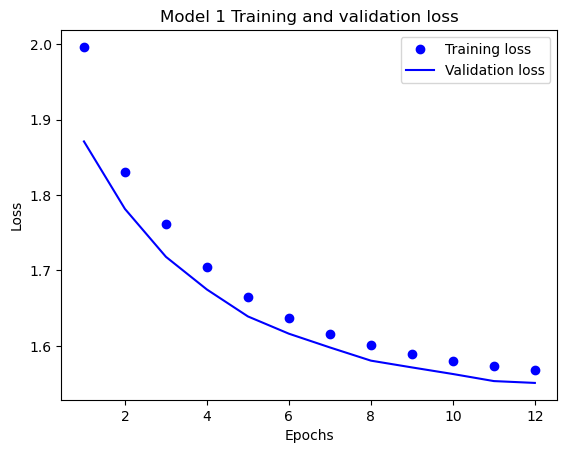

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 1 Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

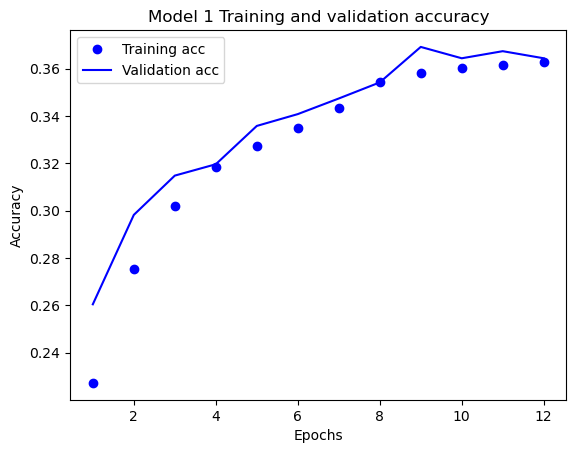

In [57]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model 1 Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [58]:
pred1 = model.predict(test_images)
pred1 = np.argmax(pred1, axis=1)

In [59]:
print_validation_report(test_labels.argmax(axis=1), pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.42      0.36      0.39       980
           1       0.46      0.91      0.61      1135
           2       0.23      0.34      0.28      1032
           3       0.23      0.42      0.29      1010
           4       0.41      0.05      0.09       982
           5       0.29      0.10      0.15       892
           6       0.59      0.66      0.62       958
           7       0.00      0.00      0.00      1028
           8       0.25      0.14      0.18       974
           9       0.40      0.56      0.46      1009

    accuracy                           0.36     10000
   macro avg       0.33      0.36      0.31     10000
weighted avg       0.33      0.36      0.31     10000

Accuracy Score: 0.3645
Root Mean Square Error: 3.7421250647192434


C:\Users\richd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\richd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\richd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrix

In [60]:
# Get the predicted classes:
pred_classes = model.predict(train_images)
conf_mx = confusion_matrix(train_labels.argmax(axis=1), pred_classes.argmax(axis=-1))
print(conf_mx)

[[1850    1 1860  123    1  119 1360    0  119   11]
 [   5 5543   19  121   11    8   14    0   13  445]
 [ 945   37 1967  919   29  299  680    0  430  164]
 [ 106  241  866 2456  113  309   29    0  777  741]
 [  29  128  243 2531  254   99   12    0  256 1755]
 [ 231   32 1793 1418   38  462   63    0  752  198]
 [1068    1  646   73    1   32 3544    0   46    6]
 [   1 4918   11  120   15    4    0    0   12  634]
 [ 132   99 1318 2052   66  409   16    0  723  574]
 [   4 1380   50  743  127   14    3    0   40 3093]]


### Visualize the Confusion Matrix
- The first matrix has the rows represent actual classes and the columns represent predicted classes
    - The first matrix is confusing 
- The second matrix is normalized to get the error rates. Only the diagonal cells should be "lit up"

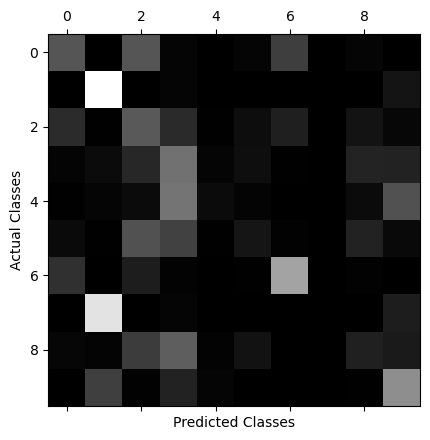

In [61]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()

In [62]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

The confusion matrix is now normalized to get the error rates and make the matrix look better

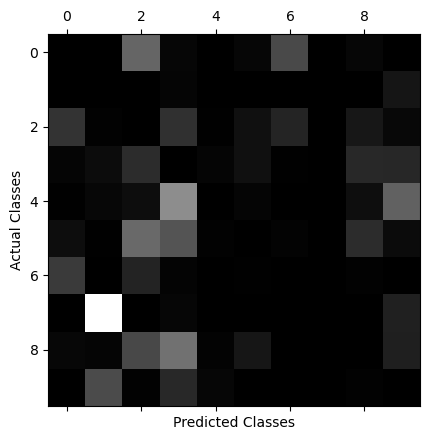

In [63]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()

Lots of the digits are still misclassified. Here are examples of 1's and 3's to see what happened on the misclassified 1's.

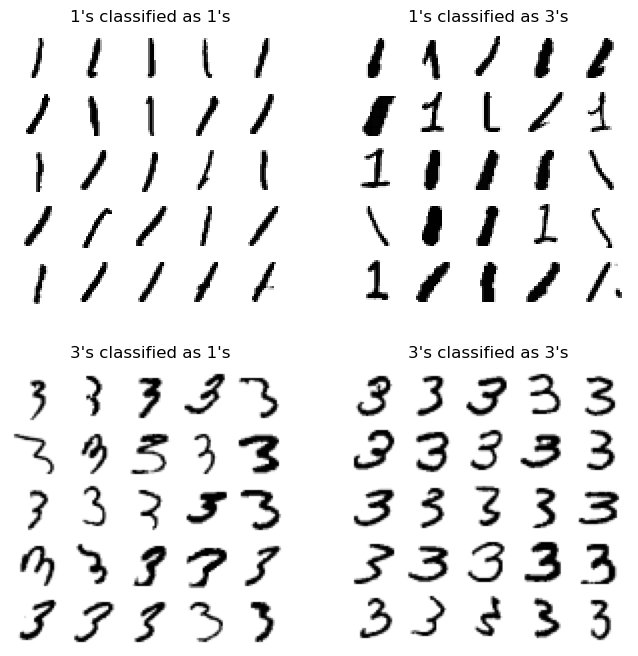

In [64]:
cl_a, cl_b = 1, 3
X_aa = train_images[(train_labels.argmax(axis=1) == cl_a) & (pred_classes.argmax(axis=-1) == cl_a)]
X_ab = train_images[(train_labels.argmax(axis=1) == cl_a) & (pred_classes.argmax(axis=-1) == cl_b)]
X_ba = train_images[(train_labels.argmax(axis=1) == cl_b) & (pred_classes.argmax(axis=-1) == cl_a)]
X_bb = train_images[(train_labels.argmax(axis=1) == cl_b) & (pred_classes.argmax(axis=-1) == cl_b)]

plt.figure(figsize=(8,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

- The upper left and lower right are correctly classified as 1's and 3's
- The upper right and lower left are incorrectly classified, and seemingly missed some obvious 1's and 3's

### Activation Values of the Hidden Nodes
After training the model, we group the activation values of the hidden node for the (original) set of training images by the 10 predicted classes and visualize these sets of values using a boxplot. We expect the overlap between the range of values in the "boxes" to be minimal.

In [65]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs # description of the layers

There are 2 layers


[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'output_layer')>]

In [66]:
# Get the output of the hidden node for each of the 55000 training images
activations = activation_model.predict(train_images)
hidden_layer_activation = activations[0]
hidden_layer_activation.shape   #  hidden node has one activation value per training image

(55000, 1)

In [67]:
# Get the output of the hidden node for each of the 55000 training images
activations = activation_model.predict(train_images)
hidden_layer_activation = activations[0]
hidden_layer_activation.shape   #  hidden node has one activation value per training image

(55000, 1)

In [68]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (55000, 10)
The output for the first image are [0.0003 0.4247 0.0011 0.0189 0.0279 0.0048 0.     0.3936 0.0092 0.1195]
The sum of the probabilities is (approximately) 0.9999998807907104


### Create the Boxplot

Use boxplots to show the actual values compared to predicted

In [69]:
boxplot_df = pd.DataFrame({'act_value':hidden_layer_activation.reshape(55000),
                           'pred_class':pred_classes.argmax(axis=-1)})
boxplot_df.head(10)

,act_value,pred_class
0,0.013243,1
1,3.978603,3
2,2.070070,9
3,9.395463,0
4,0.000000,1
5,6.058980,2
6,0.000000,1
7,9.121901,0
8,1.884531,9
9,6.469183,2


This shows how closely the hidden nodes activation values correlate with the class predictions. There were outliers for the activation values for the 6's, and no 7's were detected.

<AxesSubplot: title={'center': 'act_value'}, xlabel='pred_class'>

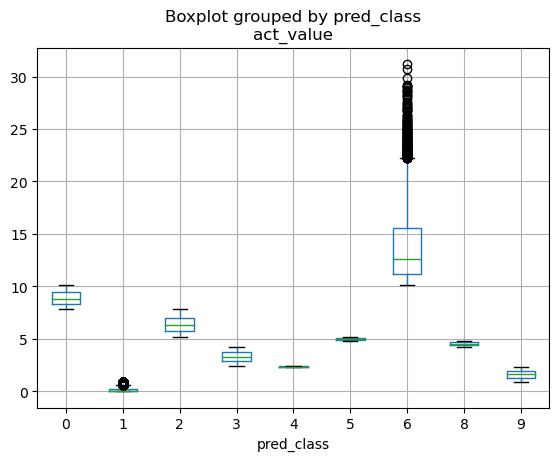

In [70]:
boxplot_df[['act_value','pred_class']].boxplot(by ='pred_class', column =['act_value'], grid = True)

In [71]:
boxplot_df['pred_class'].value_counts() # Another way to verify what the boxplot is telling us

1    12380
3    10556
2     8773
9     7621
6     5721
0     4371
8     3168
5     1755
4      655
Name: pred_class, dtype: int64

___
# Experiment 2
Here the dense neural network will have 784 input nodes, a single hidden layer with **2** neurons, and 10 output nodes that correspond to the 10 digits.
___
### Build the Model

In [72]:
model = Sequential([
    Dense(input_shape=(28*28,), units=2, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

In [73]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2)                 1570      
                                                                 
 output_layer (Dense)        (None, 10)                30        
                                                                 
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [74]:
model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

### Train the Model

In [75]:
history = model.fit(train_images,
                     train_labels,
                     epochs=100,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )

Epoch 1/100
1719/1719 [==============================] - 2s 982us/step - loss: 1.6153 - accuracy: 0.4176 - val_loss: 1.3504 - val_accuracy: 0.5006
Epoch 2/100
1719/1719 [==============================] - 2s 996us/step - loss: 1.2829 - accuracy: 0.5366 - val_loss: 1.1937 - val_accuracy: 0.5754
Epoch 3/100
1719/1719 [==============================] - 1s 865us/step - loss: 1.1639 - accuracy: 0.5918 - val_loss: 1.1093 - val_accuracy: 0.6194
Epoch 4/100
1719/1719 [==============================] - 2s 990us/step - loss: 1.0966 - accuracy: 0.6240 - val_loss: 1.0619 - val_accuracy: 0.6306
Epoch 5/100
1719/1719 [==============================] - 2s 1ms/step - loss: 1.0578 - accuracy: 0.6357 - val_loss: 1.0332 - val_accuracy: 0.6532
Epoch 6/100
1719/1719 [==============================] - 2s 1ms/step - loss: 1.0348 - accuracy: 0.6381 - val_loss: 1.0143 - val_accuracy: 0.6520
Epoch 7/100
1719/1719 [==============================] - 2s 897us/step - loss: 1.0196 - accuracy: 0.6416 - val_loss: 1.004

In [76]:
test_loss_2, test_acc_2 = model.evaluate(test_images, test_labels)

313/313 [==============================] - 0s 680us/step - loss: 0.9844 - accuracy: 0.6609


In [77]:
print(f'test acc: {test_acc_2}, test loss: {test_loss_2}')

test acc: 0.6608999967575073, test loss: 0.9843737483024597


### Plot Performance

In [78]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

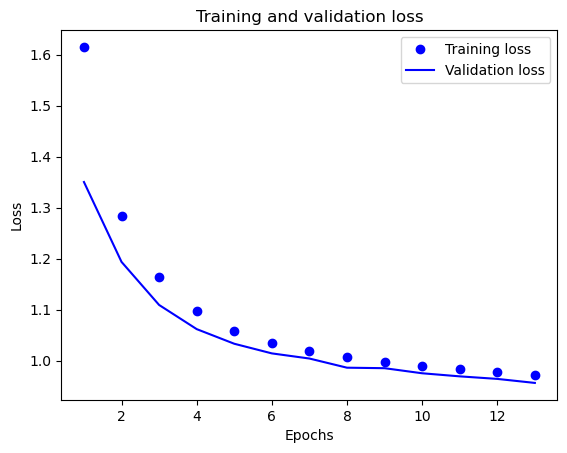

In [79]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

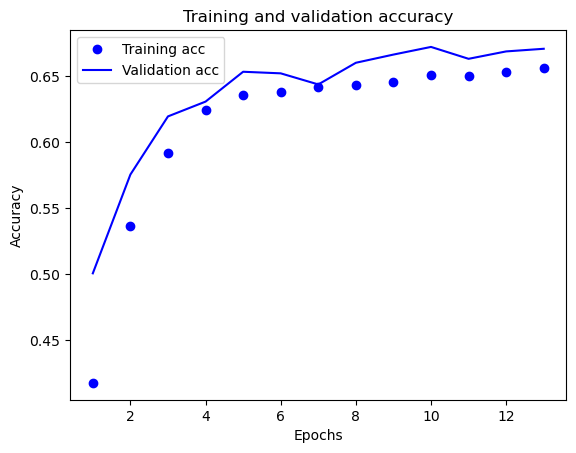

In [80]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [81]:
pred1 = model.predict(test_images)
pred1 = np.argmax(pred1, axis=1)

In [82]:
print_validation_report(test_labels.argmax(axis=1), pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       980
           1       0.84      0.95      0.89      1135
           2       0.65      0.64      0.64      1032
           3       0.55      0.55      0.55      1010
           4       0.64      0.63      0.64       982
           5       0.37      0.13      0.19       892
           6       0.81      0.79      0.80       958
           7       0.80      0.83      0.82      1028
           8       0.40      0.54      0.46       974
           9       0.63      0.65      0.64      1009

    accuracy                           0.66     10000
   macro avg       0.64      0.65      0.64     10000
weighted avg       0.65      0.66      0.65     10000

Accuracy Score: 0.6609
Root Mean Square Error: 2.2970415755923965


### Confusion Matrix

In [83]:
# Get the predicted classes:
pred_classes = model.predict(train_images)
conf_mx = confusion_matrix(train_labels.argmax(axis=1), pred_classes.argmax(axis=-1))
print(conf_mx)

[[4311    0    8    7  298  171  303    0  343    3]
 [   0 5781   44  280    3    2    0   17   37   15]
 [  38  103 3432 1104   44   96  217   18  387   31]
 [  12  745 1038 3005   27   69   33   71  597   41]
 [ 197   11    8   11 3571   40   18   57  290 1104]
 [ 364   41  347  454  440  635  227   17 2359  103]
 [ 329    2  493   52   23  160 4268    0   90    0]
 [   1  217    1   26   68    1    0 4872   55  474]
 [ 327  164  150  792  330  532  148   12 2857   77]
 [  31   21    0   12  767    3    2  989  132 3497]]


### Visualize the Confusion Matrix

In [84]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

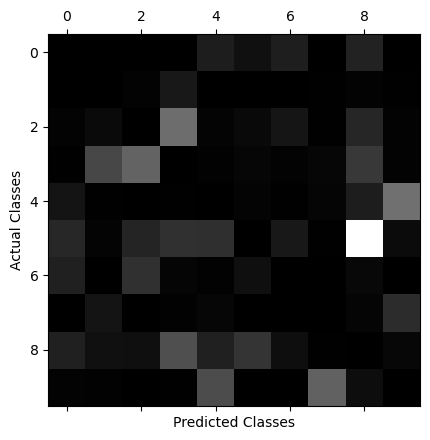

In [85]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()

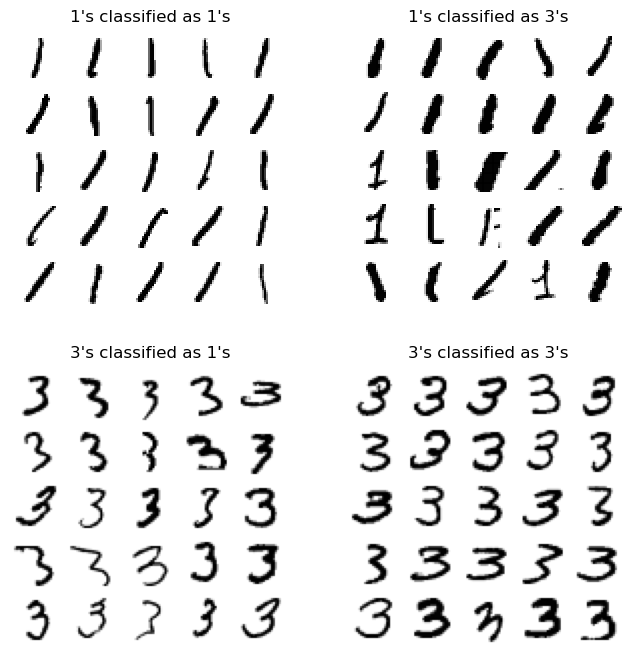

In [86]:
cl_a, cl_b = 1, 3
X_aa = train_images[(train_labels.argmax(axis=1) == cl_a) & (pred_classes.argmax(axis=-1) == cl_a)]
X_ab = train_images[(train_labels.argmax(axis=1) == cl_a) & (pred_classes.argmax(axis=-1) == cl_b)]
X_ba = train_images[(train_labels.argmax(axis=1) == cl_b) & (pred_classes.argmax(axis=-1) == cl_a)]
X_bb = train_images[(train_labels.argmax(axis=1) == cl_b) & (pred_classes.argmax(axis=-1) == cl_b)]

plt.figure(figsize=(8,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

### Activation Values of the Hidden Nodes

In [87]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs # description of the layers

There are 2 layers


[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_1')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'output_layer')>]

In [88]:
# Get the output of the hidden node for each of the 55000 training images
activations = activation_model.predict(train_images)
hidden_layer_activation = activations[0]
hidden_layer_activation.shape   #  2 hidden node each has one activation value per training image

(55000, 2)

In [89]:
hidden_node1_activation = hidden_layer_activation[:,0] # get activation values of the first hidden node
hidden_node2_activation = hidden_layer_activation[:,1] # get activation values of the second hidden node

print(f"The maximum activation value of the first hidden node is {hidden_node1_activation.max()}")
print(f"The maximum activation value of the second hidden node is {hidden_node2_activation.max()}")

The maximum activation value of the first hidden node is 30.508869171142578
The maximum activation value of the second hidden node is 47.4656867980957


In [90]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (55000, 10)
The output for the first image are [0.0001 0.0012 0.     0.0005 0.0137 0.0013 0.     0.8427 0.0024 0.1382]
The sum of the probabilities is (approximately) 1.0


### Create the Scatterplots
Activation values of the two hidden nodes are combined with the corresponding predicted classes into a DataFrame.  

In [91]:
scatterPlot_df =  pd.DataFrame({'act_value_h1':hidden_node1_activation,
                                'act_value_h2':hidden_node2_activation,
                                'pred_class':pred_classes.argmax(axis=-1)})
scatterPlot_df.head()

,act_value_h1,act_value_h2,pred_class
0,4.628421,0.118617,7
1,0.255605,4.046377,3
2,8.878266,5.018382,9
3,8.681747,16.201511,6
4,0.000000,0.000000,1


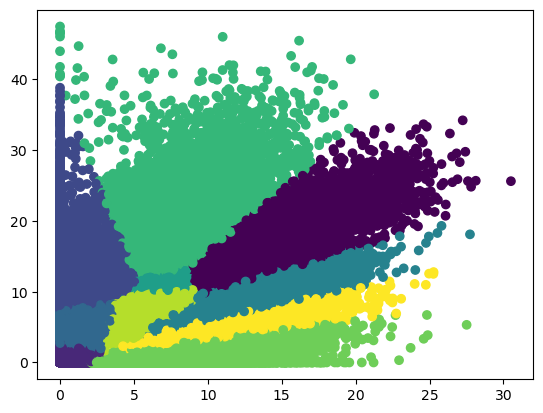

In [92]:
#plt.legend(loc='upper left', prop={'size':6}, bbox_to_anchor=(1,1),ncol=1)
plt.scatter(scatterPlot_df.act_value_h1, 
            scatterPlot_df.act_value_h2, 
            c=scatterPlot_df.pred_class,
            label=scatterPlot_df.pred_class)
plt.show()

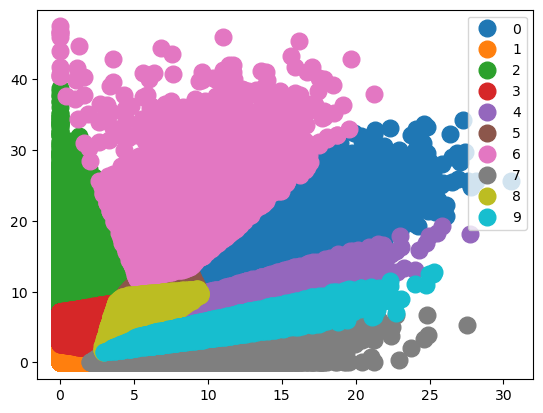

In [93]:
groups = scatterPlot_df.groupby('pred_class')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.act_value_h1, group.act_value_h2, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

___
# Experiment 3
Here we will evaluate the performance of 12 different models. We will look at using 16, 32, 64, 128, 256, and 512 neurons for both 1 and 2 hidden layers.
___
### Prepare the Data

In [94]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# reshape the images
train_images = np.reshape(train_images, (60000, 784))
test_images = np.reshape(test_images, (10000, 784))

# normalize images
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# One-hot encoding for labels
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

### Validate the Model

In [95]:
val_images, train_images = train_images[:5000], train_images[5000:]
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

### Build the Model

In [96]:
# 1st model has 1 hidden layer and 16 units
model_1_16 = Sequential([
    Dense(input_shape=(28*28,), units=16, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

# 2nd model has 1 hidden layer and 32 units
model_1_32 = Sequential([
    Dense(input_shape=(28*28,), units=32, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

# 3rd model has 1 hidden layer and 64 units
model_1_64 = Sequential([
    Dense(input_shape=(28*28,), units=64, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

# 4th model has 1 hidden layer and 128 units
model_1_128 = Sequential([
    Dense(input_shape=(28*28,), units=128, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

# 5th model has 1 hidden layers with 256 units each
model_1_256 = Sequential([
    Dense(input_shape=(28*28,), units=256, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

# 6th model has 1 hidden layers with 512 units each
model_1_512 = Sequential([
    Dense(input_shape=(28*28,), units=512, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

# 7th model has 2 hidden layers with 16 units each
model_2_16 = Sequential([
    Dense(input_shape=(28*28,), units=16, activation=tf.nn.relu),
    Dense(units=16, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

# 8th model has 2 hidden layer and 32 units
model_2_32 = Sequential([
    Dense(input_shape=(28*28,), units=32, activation=tf.nn.relu),
    Dense(units=32, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

# 9th model has 2 hidden layer and 64 units
model_2_64 = Sequential([
    Dense(input_shape=(28*28,), units=64, activation=tf.nn.relu),
    Dense(units=64, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

# 10th model has 2 hidden layers with 128 units each
model_2_128 = Sequential([
    Dense(input_shape=(28*28,), units=128, activation=tf.nn.relu),
    Dense(units=128, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

# 11th model has 2 hidden layers with 256 units each
model_2_256 = Sequential([
    Dense(input_shape=(28*28,), units=256, activation=tf.nn.relu),
    Dense(units=256, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

# 12th model has 2 hidden layers with 512 units each
model_2_512 = Sequential([
    Dense(input_shape=(28*28,), units=512, activation=tf.nn.relu),
    Dense(units=512, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

In [97]:
model_1_16.summary()
model_1_32.summary()
model_1_64.summary()
model_1_128.summary()
model_1_256.summary()
model_1_512.summary()
model_2_16.summary()
model_2_32.summary()
model_2_64.summary()
model_2_128.summary()
model_2_256.summary()
model_2_512.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                12560     
                                                                 
 output_layer (Dense)        (None, 10)                170       
                                                                 
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                25120     
                                                                 
 output_layer (Dense)        (None, 10)                330       
                                                                 
Total params: 25,450
Trainab

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 512)               401920    
                                                                 
 dense_19 (Dense)            (None, 512)               262656    
                                                                 
 output_layer (Dense)        (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


### Compile the Models

In [98]:
model_1_16.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model_1_32.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model_1_64.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model_1_128.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model_1_256.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model_1_512.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model_2_16.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model_2_32.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model_2_64.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model_2_128.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model_2_256.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model_2_512.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

### Train the Models

In [99]:
history_1_16 = model_1_16.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
history_1_32 = model_1_32.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
history_1_64 = model_1_64.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
history_1_128 = model_1_128.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
history_1_256 = model_1_256.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
history_1_512 = model_1_512.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
history_2_16 = model_2_16.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
history_2_32 = model_2_32.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
history_2_64 = model_2_64.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
history_2_128 = model_2_128.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
history_2_256 = model_2_256.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
history_2_512 = model_2_512.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )

Epoch 1/200
1719/1719 [==============================] - 2s 936us/step - loss: 0.4608 - accuracy: 0.8714 - val_loss: 0.2570 - val_accuracy: 0.9298
Epoch 2/200
1719/1719 [==============================] - 1s 864us/step - loss: 0.2500 - accuracy: 0.9296 - val_loss: 0.2210 - val_accuracy: 0.9396
Epoch 3/200
1719/1719 [==============================] - 2s 881us/step - loss: 0.2178 - accuracy: 0.9383 - val_loss: 0.1956 - val_accuracy: 0.9480
Epoch 4/200
1719/1719 [==============================] - 1s 852us/step - loss: 0.1982 - accuracy: 0.9432 - val_loss: 0.1892 - val_accuracy: 0.9494
Epoch 5/200
1719/1719 [==============================] - 1s 864us/step - loss: 0.1839 - accuracy: 0.9473 - val_loss: 0.1812 - val_accuracy: 0.9480
Epoch 6/200
1719/1719 [==============================] - 2s 888us/step - loss: 0.1736 - accuracy: 0.9498 - val_loss: 0.1728 - val_accuracy: 0.9516
Epoch 7/200
1719/1719 [==============================] - 2s 877us/step - loss: 0.1651 - accuracy: 0.9523 - val_loss: 0

1719/1719 [==============================] - 4s 2ms/step - loss: 0.0836 - accuracy: 0.9747 - val_loss: 0.0791 - val_accuracy: 0.9776
Epoch 3/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0552 - accuracy: 0.9827 - val_loss: 0.0673 - val_accuracy: 0.9790
Epoch 4/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0373 - accuracy: 0.9883 - val_loss: 0.0676 - val_accuracy: 0.9808
Epoch 5/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0268 - accuracy: 0.9913 - val_loss: 0.0764 - val_accuracy: 0.9780
Epoch 6/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0222 - accuracy: 0.9925 - val_loss: 0.0754 - val_accuracy: 0.9784
Epoch 7/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0163 - accuracy: 0.9951 - val_loss: 0.0695 - val_accuracy: 0.9812
Epoch 8/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0135 - accuracy: 0.9956 - val_loss: 0.0816 - val_accuracy: 0.98

1719/1719 [==============================] - 2s 1ms/step - loss: 0.0266 - accuracy: 0.9914 - val_loss: 0.0867 - val_accuracy: 0.9766
Epoch 8/200
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0244 - accuracy: 0.9921 - val_loss: 0.0881 - val_accuracy: 0.9782
Epoch 1/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2084 - accuracy: 0.9373 - val_loss: 0.1134 - val_accuracy: 0.9650
Epoch 2/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0865 - accuracy: 0.9735 - val_loss: 0.0870 - val_accuracy: 0.9748
Epoch 3/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0590 - accuracy: 0.9811 - val_loss: 0.0731 - val_accuracy: 0.9798
Epoch 4/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0438 - accuracy: 0.9861 - val_loss: 0.0845 - val_accuracy: 0.9764
Epoch 5/200
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0349 - accuracy: 0.9888 - val_loss: 0.0850 - val_accuracy: 0.97

### Test the Models

In [100]:
test_loss_1_16, test_acc_1_16 = model_1_16.evaluate(test_images, test_labels)
test_loss_1_32, test_acc_1_32 = model_1_32.evaluate(test_images, test_labels)
test_loss_1_64, test_acc_1_64 = model_1_64.evaluate(test_images, test_labels)
test_loss_1_128, test_acc_1_128 = model_1_128.evaluate(test_images, test_labels)
test_loss_1_256, test_acc_1_256 = model_1_256.evaluate(test_images, test_labels)
test_loss_1_512, test_acc_1_512 = model_1_512.evaluate(test_images, test_labels)
test_loss_2_16, test_acc_2_16 = model_2_16.evaluate(test_images, test_labels)
test_loss_2_32, test_acc_2_32 = model_2_32.evaluate(test_images, test_labels)
test_loss_2_64, test_acc_2_64 = model_2_64.evaluate(test_images, test_labels)
test_loss_2_128, test_acc_2_128 = model_2_128.evaluate(test_images, test_labels)
test_loss_2_256, test_acc_2_256 = model_2_256.evaluate(test_images, test_labels)
test_loss_2_512, test_acc_2_512 = model_2_512.evaluate(test_images, test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.1366 - accuracy: 0.9779


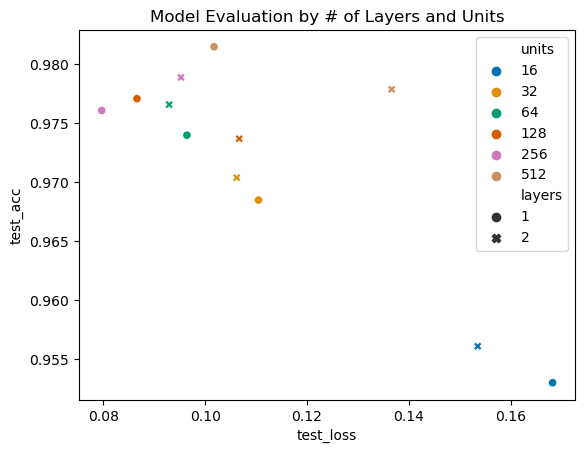

In [101]:
test_acc_df = [test_acc_1_16, test_acc_1_32, test_acc_1_64, test_acc_1_128, test_acc_1_256, test_acc_1_512,
               test_acc_2_16, test_acc_2_32, test_acc_2_64, test_acc_2_128, test_acc_2_256, test_acc_2_512]
test_loss_df = [test_loss_1_16, test_loss_1_32, test_loss_1_64, test_loss_1_128, test_loss_1_256, test_loss_1_512,
                test_loss_2_16, test_loss_2_32, test_loss_2_64, test_loss_2_128, test_loss_2_256, test_loss_2_512]
num_layers = [1,1,1,1,1,1,2,2,2,2,2,2]
num_units = [16,32,64,128,256,512,16,32,64,128,256,512]


model_df =  pd.DataFrame({'test_acc':test_acc_df,
                                'test_loss':test_loss_df,
                                'layers':num_layers,
                                 'units':num_units})

ax = sns.scatterplot(data=model_df, x='test_loss', y='test_acc', hue='units', style='layers', palette='colorblind')
plt.legend()
plt.title('Model Evaluation by # of Layers and Units')
plt.show()

### Plot Performance

In [102]:
history_dict_1_512 = history_1_512.history
history_dict.keys()

history_dict_1_128 = history_1_128.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

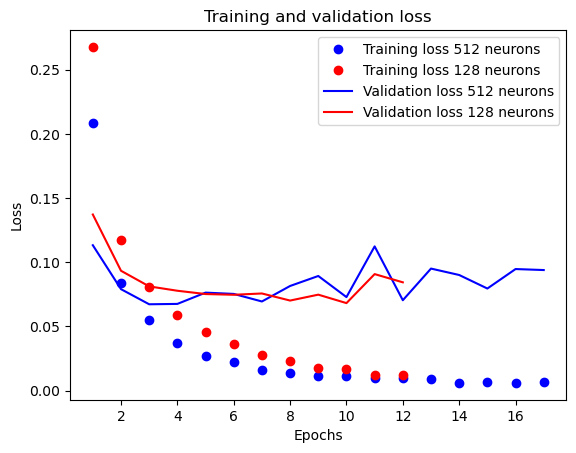

In [103]:
acc = history_1_512.history['accuracy']
val_acc = history_1_512.history['val_accuracy']
loss = history_1_512.history['loss']
val_loss = history_1_512.history['val_loss']

acc_2 = history_1_128.history['accuracy']
val_acc_2 = history_1_128.history['val_accuracy']
loss_2 = history_1_128.history['loss']
val_loss_2 = history_1_128.history['val_loss']

epochs = range(1, len(acc) + 1)
epochs_2 = range(1, len(acc_2) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss 512 neurons')
plt.plot(epochs_2, loss_2, 'ro', label='Training loss 128 neurons')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss 512 neurons')
plt.plot(epochs_2, val_loss_2, 'r', label='Validation loss 128 neurons')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

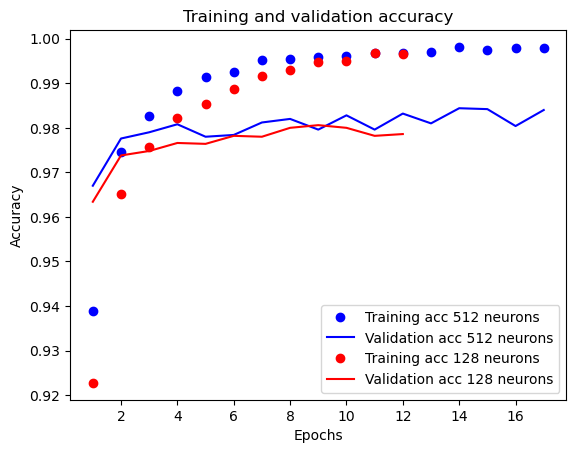

In [104]:
plt.clf()   # clear figure
acc_values = history_dict_1_512['accuracy']
acc_values_2 = history_dict_1_128['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc 512 neurons')
plt.plot(epochs, val_acc, 'b', label='Validation acc 512 neurons')
plt.plot(epochs_2, acc_2, 'ro', label='Training acc 128 neurons')
plt.plot(epochs_2, val_acc_2, 'r', label='Validation acc 128 neurons')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [105]:
pred1 = model_1_128.predict(test_images)
pred1 = np.argmax(pred1, axis=1)

In [106]:
print("Model_1_512")
print_validation_report(test_labels.argmax(axis=1), pred1)

Model_1_512
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.96      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Accuracy Score: 0.9771
Root Mean Square Error: 0.6511528238439882


In [107]:
pred1 = model_1_512.predict(test_images)
pred1 = np.argmax(pred1, axis=1)

In [108]:
print_validation_report(test_labels.argmax(axis=1), pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.99      0.97      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.96      0.98      0.97       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Accuracy Score: 0.9815
Root Mean Square Error: 0.5630275304103699


I decided to choose the model with 1 layer and 512 neurons over the remaining, particularly the model with 1 layer and 128 neurons. I ultimately made the pick because of the slight improvements of test accuracy and loss.

### Confusion Matrix

In [109]:
# Get the predicted classes:
pred_classes = model_1_512.predict(train_images)
conf_mx = confusion_matrix(train_labels.argmax(axis=1), pred_classes.argmax(axis=-1))
print(conf_mx)

[[5440    0    4    0    0    0    0    0    0    0]
 [   0 6178    0    0    0    0    0    1    0    0]
 [   0    0 5469    0    0    0    0    0    0    1]
 [   0    0   10 5627    0    0    0    0    1    0]
 [   0    0    0    0 5306    0    0    0    0    1]
 [   1    0    1    3    0 4974    1    0    3    4]
 [   1    0    0    0    1    0 5413    0    2    0]
 [   0    0    1    0    1    0    0 5709    1    3]
 [   1    1    3    0    0    0    0    0 5384    0]
 [   0    0    1    1    2    1    0    0    0 5449]]


### Visualize the Confusion Matrix

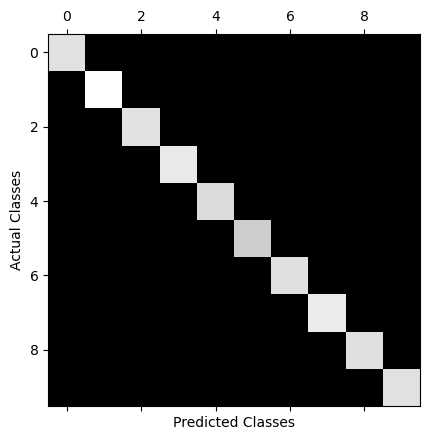

In [110]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()

In [111]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

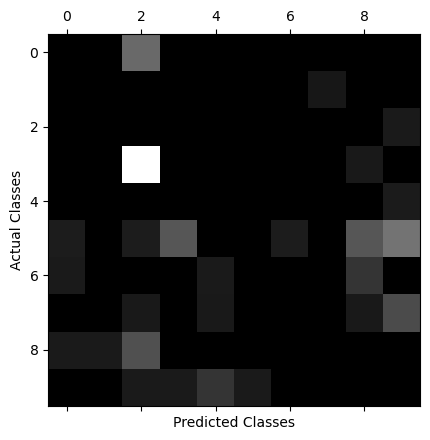

In [112]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()

### Activation Values of the Hidden Nodes

In [113]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model_1_512.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model_1_512.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs # description of the layers

There are 2 layers


[<KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'dense_7')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'output_layer')>]

In [114]:
# Get the output of the hidden node for each of the 55000 training images
activations = activation_model.predict(train_images)
hidden_layer_activation = activations[0]
hidden_layer_activation.shape   #  2 hidden node each has one activation value per training image

(55000, 512)

In [115]:
hidden_node1_activation = hidden_layer_activation[:,0] # get activation values of the first hidden node
hidden_node2_activation = hidden_layer_activation[:,1] # get activation values of the second hidden node

print(f"The maximum activation value of the first hidden node is {hidden_node1_activation.max()}")
print(f"The maximum activation value of the second hidden node is {hidden_node2_activation.max()}")

The maximum activation value of the first hidden node is 11.206805229187012
The maximum activation value of the second hidden node is 6.923328876495361


In [116]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (55000, 10)
The output for the first image are [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
The sum of the probabilities is (approximately) 1.0


### Create the Scatterplots

In [117]:
scatterPlot_df =  pd.DataFrame({'act_value_h1':hidden_node1_activation,
                                'act_value_h2':hidden_node2_activation,
                                'pred_class':pred_classes.argmax(axis=-1)})
scatterPlot_df.head()

,act_value_h1,act_value_h2,pred_class
0,0.0,2.074041,7
1,0.0,0.000000,3
2,0.0,0.000000,4
3,0.0,2.183814,6
4,0.0,0.000000,1


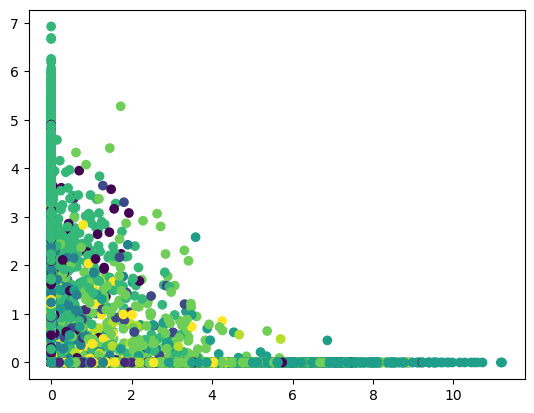

In [118]:
#plt.legend(loc='upper left', prop={'size':6}, bbox_to_anchor=(1,1),ncol=1)
plt.scatter(scatterPlot_df.act_value_h1, 
            scatterPlot_df.act_value_h2, 
            c=scatterPlot_df.pred_class,
            label=scatterPlot_df.pred_class)
plt.show()

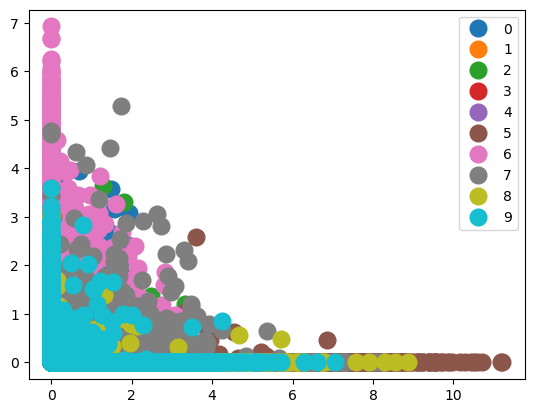

In [119]:
groups = scatterPlot_df.groupby('pred_class')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.act_value_h1, group.act_value_h2, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

___
# Experiment 4
Here we will use PCA to reduce the number of dimensions in the training set from 784 to 154.
___
### Using PCA decomposition to reduce dimensionality
By setting the n_components=0.95 we get the 154 principal components that contain 95% of the variance (information) in the training images. We transform the training images to reduce its dimensionality from 784 to 154. 

In [120]:
pca = PCA(n_components=0.95)
train_images_red = pca.fit_transform(train_images)
val_images_red = pca.transform(val_images)
test_images_red = pca.transform(test_images)

In [121]:
test_images_red.shape, train_images_red.shape, val_images_red.shape

((10000, 154), (55000, 154), (5000, 154))

### Build the Model

In [122]:
model = Sequential([
    Dense(input_shape=(28*28,), units=512, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

In [123]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 512)               401920    
                                                                 
 output_layer (Dense)        (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


### Complile the Model

In [124]:
model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

### Train the Model

In [125]:
history = model.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
history_dict = history.history
history_dict.keys()

Epoch 1/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2091 - accuracy: 0.9384 - val_loss: 0.1140 - val_accuracy: 0.9646
Epoch 2/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0827 - accuracy: 0.9752 - val_loss: 0.0881 - val_accuracy: 0.9740
Epoch 3/200
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0552 - accuracy: 0.9827 - val_loss: 0.0697 - val_accuracy: 0.9788
Epoch 4/200
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0380 - accuracy: 0.9875 - val_loss: 0.0630 - val_accuracy: 0.9812
Epoch 5/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0278 - accuracy: 0.9912 - val_loss: 0.0695 - val_accuracy: 0.9816
Epoch 6/200
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0233 - accuracy: 0.9923 - val_loss: 0.0682 - val_accuracy: 0.9826
Epoch 7/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0173 - accuracy: 0.9943 - val_loss: 0.0713 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Test the Model

In [126]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.1006 - accuracy: 0.9782


In [127]:
print(f'test acc: {test_acc}, test loss: {test_loss}')

test acc: 0.9782000184059143, test loss: 0.1006443053483963


### Building, training and testing the model on the new data

In [128]:
model_pca = Sequential([
    Dense(input_shape=(train_images_red.shape[1],), units=512, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

model_pca.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
# train the model
history_pca = model_pca.fit(train_images_red,
                    train_labels,
                    epochs=200,
                    validation_data=(val_images_red, val_labels),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                   )

Epoch 1/200
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2180 - accuracy: 0.9393 - val_loss: 0.1028 - val_accuracy: 0.9716
Epoch 2/200
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0784 - accuracy: 0.9773 - val_loss: 0.0829 - val_accuracy: 0.9742
Epoch 3/200
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0457 - accuracy: 0.9870 - val_loss: 0.0683 - val_accuracy: 0.9798
Epoch 4/200
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0273 - accuracy: 0.9921 - val_loss: 0.0716 - val_accuracy: 0.9800
Epoch 5/200
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0173 - accuracy: 0.9951 - val_loss: 0.0657 - val_accuracy: 0.9834
Epoch 6/200
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0099 - accuracy: 0.9976 - val_loss: 0.0744 - val_accuracy: 0.9814
Epoch 7/200
1719/1719 [==============================] - 3s 1ms/step - loss: 0.0062 - accuracy: 0.9985 - val_loss: 0.0773 - val_ac

In [129]:
hist_dict_pca = history_pca.history
hist_dict_pca.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [130]:
print(f'''acc: {hist_dict_pca['accuracy'][-1]:.4}, val acc: {hist_dict_pca['val_accuracy'][-1]:.4},
loss: {hist_dict_pca['loss'][-1]:.4}, val loss: {hist_dict_pca['val_loss'][-1]:.4}''')

acc: 0.9991, val acc: 0.9828,
loss: 0.003632, val loss: 0.08299


### Test the Model

In [131]:
test_loss_pca, test_acc_pca = model_pca.evaluate(test_images_red, test_labels)

313/313 [==============================] - 0s 937us/step - loss: 0.0816 - accuracy: 0.9809


In [132]:
print(f'test acc pca: {test_acc_pca}, test loss pca: {test_loss_pca}')  

test acc pca: 0.98089998960495, test loss pca: 0.08156803995370865


### Plot Performance

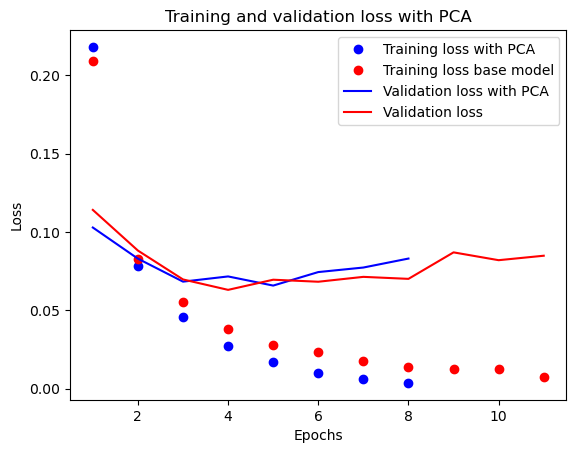

In [133]:
acc = history_pca.history['accuracy']
val_acc = history_pca.history['val_accuracy']
loss = history_pca.history['loss']
val_loss = history_pca.history['val_loss']

acc_2 = history.history['accuracy']
val_acc_2 = history.history['val_accuracy']
loss_2 = history.history['loss']
val_loss_2 = history.history['val_loss']

epochs = range(1, len(acc) + 1)
epochs_2 = range(1, len(acc_2) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss with PCA')
plt.plot(epochs_2, loss_2, 'ro', label='Training loss base model')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss with PCA')
plt.plot(epochs_2, val_loss_2, 'r', label='Validation loss')
plt.title('Training and validation loss with PCA')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

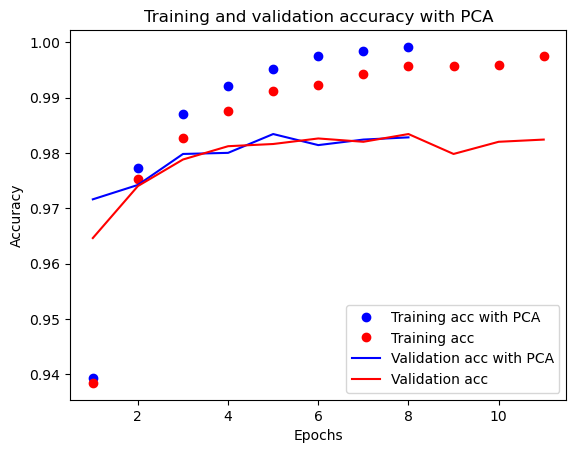

In [134]:
plt.clf()   # clear figure
acc_values = hist_dict_pca['accuracy']
acc_values_2 = history_dict['accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc with PCA')
plt.plot(epochs_2, acc_2, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc with PCA')
plt.plot(epochs_2, val_acc_2, 'r', label='Validation acc')
plt.title('Training and validation accuracy with PCA')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

___
# Experiment 5
Here we will use a Random Forest classifier to get the relative importance of 784 features and select the top 70 features (pixels). We train the 'best' dense neural network from before using these 70 features to compare its performance to previous models.
___
### Using Random Forests to reduce dimensionality of the data

In [135]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(train_images,train_labels)

RandomForestClassifier(random_state=42)

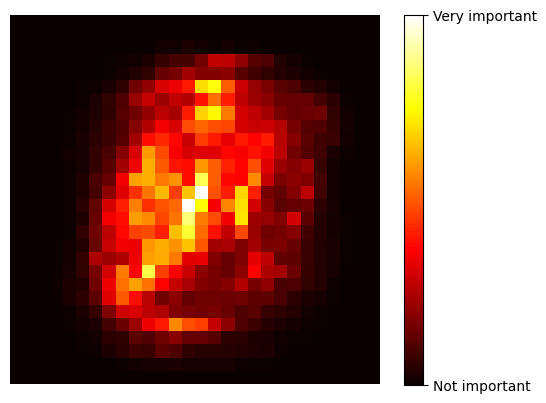

In [136]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

# plt.savefig("mnist_feature_importance_plot")
plt.show()

In [137]:
# https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
n = 70
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]          # get the indices of the 70 "most important" features/pixels
len(idx)

# Create training, validation and test images using just the 70 pixel locations obtained above
train_images_sm = train_images[:,idx]
val_images_sm = val_images[:,idx]
test_images_sm = test_images[:,idx]
train_images_sm.shape, val_images.shape, test_images_sm.shape # the reduced images have dimension 70

((55000, 70), (5000, 784), (10000, 70))

### Visualizing the 70 pixels

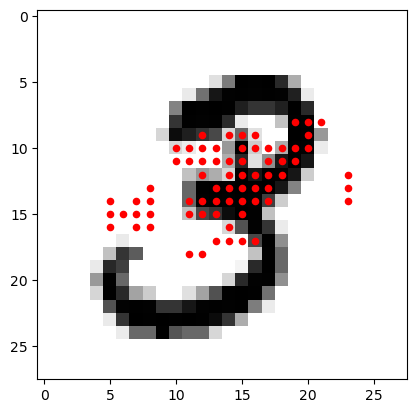

In [138]:
plt.imshow(train_images[1].reshape(28,28),cmap='binary')
x, y = np.array([pair(k,28) for k in idx]).T
plt.scatter(x,y,color='red',s=20)

### Building, training and testing the model on the new data

In [139]:
model = Sequential([
    Dense(input_shape=(train_images_sm.shape[1],), units=512, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
# train the model
history_rf = model.fit(train_images_sm,
                    train_labels,
                    epochs=200,
                    validation_data=(val_images_sm, val_labels),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                   )

Epoch 1/200
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4742 - accuracy: 0.8566 - val_loss: 0.3089 - val_accuracy: 0.9108
Epoch 2/200
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2815 - accuracy: 0.9143 - val_loss: 0.2457 - val_accuracy: 0.9280
Epoch 3/200
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2289 - accuracy: 0.9305 - val_loss: 0.2199 - val_accuracy: 0.9350
Epoch 4/200
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2022 - accuracy: 0.9376 - val_loss: 0.1975 - val_accuracy: 0.9418
Epoch 5/200
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1834 - accuracy: 0.9430 - val_loss: 0.2105 - val_accuracy: 0.9404
Epoch 6/200
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1710 - accuracy: 0.9471 - val_loss: 0.1926 - val_accuracy: 0.9452
Epoch 7/200
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1601 - accuracy: 0.9512 - val_loss: 0.1921 - val_ac

In [140]:
hist_dict_rf = history_rf.history
hist_dict_rf.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [141]:
print(f'''acc: {hist_dict_rf['accuracy'][-1]:.4}, val acc: {hist_dict_rf['val_accuracy'][-1]:.4},
loss: {hist_dict_rf['loss'][-1]:.4}, val loss: {hist_dict_rf['val_loss'][-1]:.4}''')

acc: 0.9705, val acc: 0.9518,
loss: 0.0993, val loss: 0.2068


### Test the Model

In [142]:
test_loss_rf, test_acc_rf = model.evaluate(test_images_sm, test_labels)

313/313 [==============================] - 0s 808us/step - loss: 0.2125 - accuracy: 0.9459


In [143]:
print(f'test acc random forest: {test_acc_rf}, test loss pca: {test_loss_rf}')  

test acc random forest: 0.945900022983551, test loss pca: 0.21253466606140137


### Plot Performance

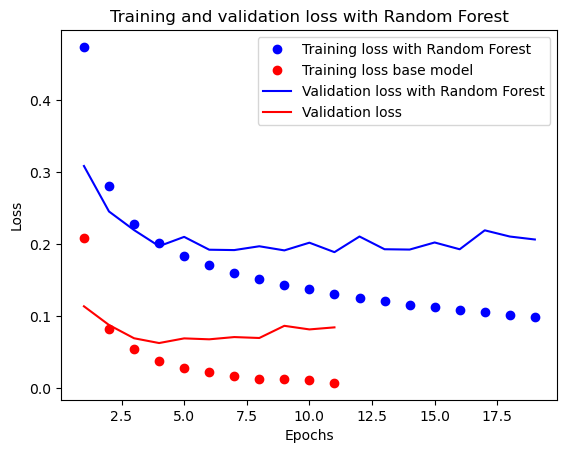

In [144]:
acc = history_rf.history['accuracy']
val_acc = history_rf.history['val_accuracy']
loss = history_rf.history['loss']
val_loss = history_rf.history['val_loss']

acc_2 = history.history['accuracy']
val_acc_2 = history.history['val_accuracy']
loss_2 = history.history['loss']
val_loss_2 = history.history['val_loss']

epochs = range(1, len(acc) + 1)
epochs_2 = range(1, len(acc_2) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss with Random Forest')
plt.plot(epochs_2, loss_2, 'ro', label='Training loss base model')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss with Random Forest')
plt.plot(epochs_2, val_loss_2, 'r', label='Validation loss')
plt.title('Training and validation loss with Random Forest')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

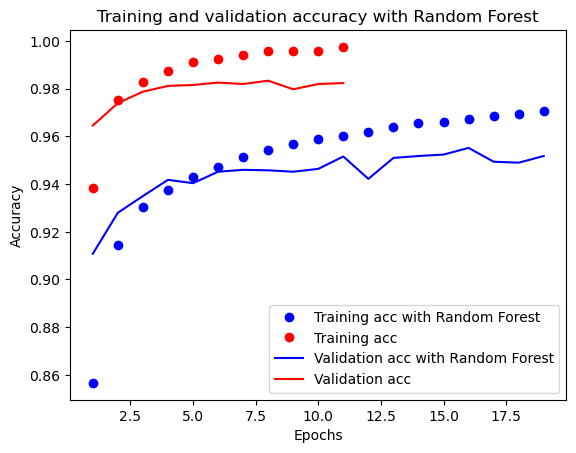

In [145]:
plt.clf()   # clear figure
acc_values = hist_dict_rf['accuracy']
acc_values_2 = history_dict['accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc with Random Forest')
plt.plot(epochs_2, acc_2, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc with Random Forest')
plt.plot(epochs_2, val_acc_2, 'r', label='Validation acc')
plt.title('Training and validation accuracy with Random Forest')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

___
# Experiment 6
Here we'll see the impact of adding an L1 and L2 regularizer of equal levels to the model. We'll experiment with using L1 and L2 regularizer levels of 0.01, 0.001, and 0.0001.
___
### Test Different L1/L2 Regularizer Levels

In [146]:
model_l1_l2_01 = Sequential([
    Dense(input_shape=(28*28,), units=512, activation=tf.nn.relu,
          kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])


model_l1_l2_001 = Sequential([
    Dense(input_shape=(28*28,), units=512, activation=tf.nn.relu,
          kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])


model_l1_l2_0001 = Sequential([
    Dense(input_shape=(28*28,), units=512, activation=tf.nn.relu,
          kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001)),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

In [147]:
model_l1_l2_01.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model_l1_l2_001.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model_l1_l2_0001.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [148]:
history_l1_l2_01 = model_l1_l2_01.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
history_l1_l2_001 = model_l1_l2_001.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
history_l1_l2_0001 = model_l1_l2_0001.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )

Epoch 1/200
1719/1719 [==============================] - 8s 5ms/step - loss: 3.9801 - accuracy: 0.7937 - val_loss: 1.5993 - val_accuracy: 0.8454
Epoch 2/200
1719/1719 [==============================] - 9s 5ms/step - loss: 1.5545 - accuracy: 0.8492 - val_loss: 1.4991 - val_accuracy: 0.8636
Epoch 3/200
1719/1719 [==============================] - 9s 5ms/step - loss: 1.4569 - accuracy: 0.8565 - val_loss: 1.3978 - val_accuracy: 0.8710
Epoch 4/200
1719/1719 [==============================] - 8s 5ms/step - loss: 1.4030 - accuracy: 0.8640 - val_loss: 1.3522 - val_accuracy: 0.8700
Epoch 5/200
1719/1719 [==============================] - 8s 5ms/step - loss: 1.3651 - accuracy: 0.8671 - val_loss: 1.3654 - val_accuracy: 0.8814
Epoch 6/200
1719/1719 [==============================] - 8s 5ms/step - loss: 1.3453 - accuracy: 0.8701 - val_loss: 1.3276 - val_accuracy: 0.8774
Epoch 7/200
1719/1719 [==============================] - 7s 4ms/step - loss: 1.3317 - accuracy: 0.8710 - val_loss: 1.2698 - val_ac

In [149]:
test_loss_l1_l2_01, test_acc_l1_l2_01 = model_l1_l2_01.evaluate(test_images, test_labels)
test_loss_l1_l2_001, test_acc_l1_l2_001 = model_l1_l2_001.evaluate(test_images, test_labels)
test_loss_l1_l2_0001, test_acc_l1_l2_0001 = model_l1_l2_0001.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.2130 - accuracy: 0.9704


In [150]:
print(f'test acc L1 and L2 at 0.01: {test_acc_l1_l2_01}, test loss L1 and L2 at 0.01: {test_loss_l1_l2_01}')
print(f'test acc L1 and L2 at 0.001: {test_acc_l1_l2_001}, test loss L1 and L2 at 0.001: {test_loss_l1_l2_001}')
print(f'test acc L1 and L2 at 0.0001: {test_acc_l1_l2_0001}, test loss L1 and L2 at 0.0001: {test_loss_l1_l2_0001}')

test acc L1 and L2 at 0.01: 0.8867999911308289, test loss L1 and L2 at 0.01: 1.238316535949707
test acc L1 and L2 at 0.001: 0.9581000208854675, test loss L1 and L2 at 0.001: 0.39794957637786865
test acc L1 and L2 at 0.0001: 0.9703999757766724, test loss L1 and L2 at 0.0001: 0.21297341585159302


### Plot Performance

In [151]:
history_dict_l1_l2_0001 = history_l1_l2_0001.history
history_dict_l1_l2_0001.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

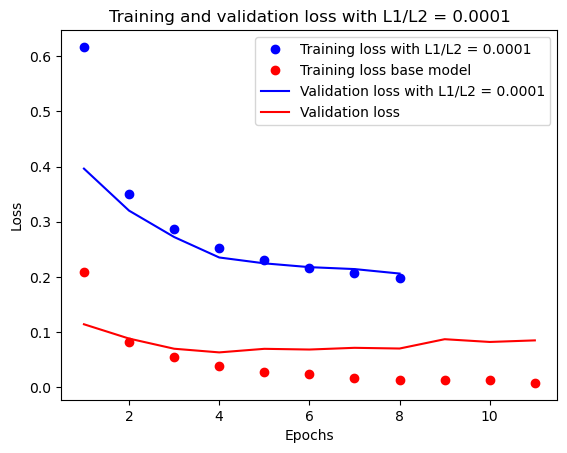

In [152]:
acc = history_l1_l2_0001.history['accuracy']
val_acc = history_l1_l2_0001.history['val_accuracy']
loss = history_l1_l2_0001.history['loss']
val_loss = history_l1_l2_0001.history['val_loss']

acc_2 = history.history['accuracy']
val_acc_2 = history.history['val_accuracy']
loss_2 = history.history['loss']
val_loss_2 = history.history['val_loss']

epochs = range(1, len(acc) + 1)
epochs_2 = range(1, len(acc_2) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss with L1/L2 = 0.0001')
plt.plot(epochs_2, loss_2, 'ro', label='Training loss base model')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss with L1/L2 = 0.0001')
plt.plot(epochs_2, val_loss_2, 'r', label='Validation loss')
plt.title('Training and validation loss with L1/L2 = 0.0001')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

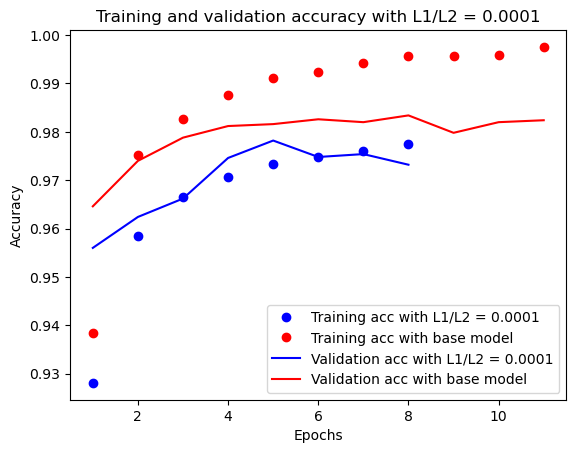

In [153]:
plt.clf()   # clear figure
acc_values = history_dict_l1_l2_0001['accuracy']
acc_values_2 = history_dict['accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc with L1/L2 = 0.0001')
plt.plot(epochs_2, acc_2, 'ro', label='Training acc with base model')
plt.plot(epochs, val_acc, 'b', label='Validation acc with L1/L2 = 0.0001')
plt.plot(epochs_2, val_acc_2, 'r', label='Validation acc with base model')
plt.title('Training and validation accuracy with L1/L2 = 0.0001')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

___
# Experiment 7
Here we'll look at the impact of adding a dropout rate to the model. This will compare the base model to those adding dropout rates of 0.3, 0.4, and 0.5
___
### Test Different Dropout Rates

In [154]:
model_dropout_3 = Sequential([
    Dense(input_shape=(28*28,), units=512, activation=tf.nn.relu),
    Dropout(0.3),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

model_dropout_4 = Sequential([
    Dense(input_shape=(28*28,), units=512, activation=tf.nn.relu),
    Dropout(0.4),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

model_dropout_5 = Sequential([
    Dense(input_shape=(28*28,), units=512, activation=tf.nn.relu),
    Dropout(0.5),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

In [155]:
model_dropout_3.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model_dropout_4.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model_dropout_5.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [156]:
history_dropout_3 = model_dropout_3.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
history_dropout_4 = model_dropout_4.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
history_dropout_5 = model_dropout_5.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )

Epoch 1/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2425 - accuracy: 0.9283 - val_loss: 0.1106 - val_accuracy: 0.9682
Epoch 2/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1131 - accuracy: 0.9657 - val_loss: 0.0816 - val_accuracy: 0.9756
Epoch 3/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0798 - accuracy: 0.9749 - val_loss: 0.0691 - val_accuracy: 0.9794
Epoch 4/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0632 - accuracy: 0.9791 - val_loss: 0.0690 - val_accuracy: 0.9800
Epoch 5/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0558 - accuracy: 0.9818 - val_loss: 0.0645 - val_accuracy: 0.9812
Epoch 6/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0462 - accuracy: 0.9841 - val_loss: 0.0615 - val_accuracy: 0.9820
Epoch 7/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0397 - accuracy: 0.9871 - val_loss: 0.0629 - val_ac

In [157]:
test_loss_dropout_3, test_acc_dropout_3 = model_dropout_3.evaluate(test_images, test_labels)
print(f'test acc Dropout at 0.3: {test_acc_dropout_3}, test loss Dropout at 0.3: {test_loss_dropout_3}')
test_loss_dropout_4, test_acc_dropout_4 = model_dropout_4.evaluate(test_images, test_labels)
print(f'test acc Dropout at 0.4: {test_acc_dropout_4}, test loss Dropout at 0.4: {test_loss_dropout_4}')
test_loss_dropout_5, test_acc_dropout_5 = model_dropout_5.evaluate(test_images, test_labels)
print(f'test acc Dropout at 0.5: {test_acc_dropout_5}, test loss Dropout at 0.5: {test_loss_dropout_5}')

313/313 [==============================] - 0s 1ms/step - loss: 0.0791 - accuracy: 0.9807
test acc Dropout at 0.3: 0.9807000160217285, test loss Dropout at 0.3: 0.07907728850841522
313/313 [==============================] - 0s 1ms/step - loss: 0.0719 - accuracy: 0.9791
test acc Dropout at 0.4: 0.9790999889373779, test loss Dropout at 0.4: 0.07185068726539612
313/313 [==============================] - 0s 1ms/step - loss: 0.0682 - accuracy: 0.9809
test acc Dropout at 0.5: 0.98089998960495, test loss Dropout at 0.5: 0.06823335587978363


### Plot Performance

In [158]:
history_dict_dropout_5 = history_dropout_5.history
history_dict_dropout_5.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

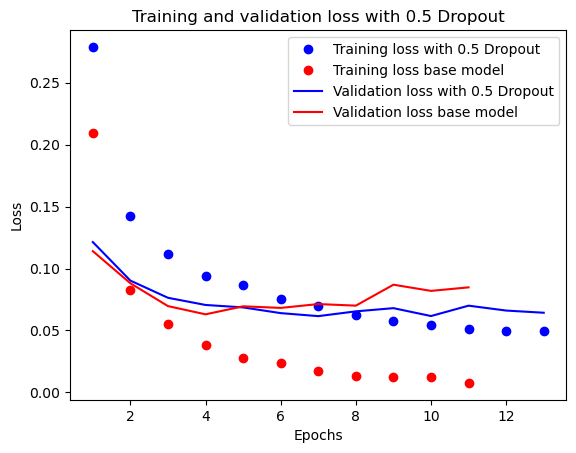

In [159]:
acc = history_dropout_5.history['accuracy']
val_acc = history_dropout_5.history['val_accuracy']
loss = history_dropout_5.history['loss']
val_loss = history_dropout_5.history['val_loss']

acc_2 = history.history['accuracy']
val_acc_2 = history.history['val_accuracy']
loss_2 = history.history['loss']
val_loss_2 = history.history['val_loss']

epochs = range(1, len(acc) + 1)
epochs_2 = range(1, len(acc_2) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss with 0.5 Dropout')
plt.plot(epochs_2, loss_2, 'ro', label='Training loss base model')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss with 0.5 Dropout')
plt.plot(epochs_2, val_loss_2, 'r', label='Validation loss base model')
plt.title('Training and validation loss with 0.5 Dropout')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

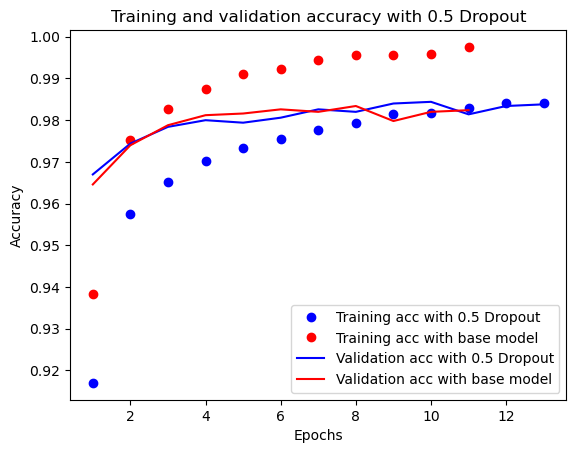

In [160]:
plt.clf()   # clear figure
acc_values = history_dict_dropout_5['accuracy']
acc_values_2 = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc with 0.5 Dropout')
plt.plot(epochs_2, acc_2, 'ro', label='Training acc with base model')
plt.plot(epochs, val_acc, 'b', label='Validation acc with 0.5 Dropout')
plt.plot(epochs_2, val_acc_2, 'r', label='Validation acc with base model')
plt.title('Training and validation accuracy with 0.5 Dropout')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

___
# Experiment 8
Here we'll see how adjusting the learning rate impacts the model. The default learning rate is 0.001 for the Adam optimizer. This will compare the base model to learning rates of 0.05, 0.0001, and 0.00001. 
___
### Test Different Learning Rates

In [161]:
model_lr_pt05 = Sequential([
    Dense(input_shape=(28*28,), units=512, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])
model_lr_pt0001 = Sequential([
    Dense(input_shape=(28*28,), units=512, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])
model_lr_pt00001 = Sequential([
    Dense(input_shape=(28*28,), units=512, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

In [162]:
model_lr_pt05.compile(tf.keras.optimizers.Adam(learning_rate=0.05),
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model_lr_pt0001.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model_lr_pt00001.compile(tf.keras.optimizers.Adam(learning_rate=0.00001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [163]:
history_lr_pt05 = model_lr_pt05.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
history_lr_pt0001 = model_lr_pt0001.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
history_lr_pt00001 = model_lr_pt00001.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )

Epoch 1/200
1719/1719 [==============================] - 5s 2ms/step - loss: 0.6230 - accuracy: 0.8613 - val_loss: 0.4469 - val_accuracy: 0.8936
Epoch 2/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5624 - accuracy: 0.8761 - val_loss: 0.4879 - val_accuracy: 0.8844
Epoch 3/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5599 - accuracy: 0.8748 - val_loss: 0.4607 - val_accuracy: 0.8964
Epoch 4/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5432 - accuracy: 0.8759 - val_loss: 0.5255 - val_accuracy: 0.8822
Epoch 5/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5381 - accuracy: 0.8704 - val_loss: 0.6045 - val_accuracy: 0.8364
Epoch 6/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5633 - accuracy: 0.8625 - val_loss: 0.5911 - val_accuracy: 0.8820
Epoch 1/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4625 - accuracy: 0.8850 - val_loss: 0.2405 - val_ac

1719/1719 [==============================] - 4s 2ms/step - loss: 0.1353 - accuracy: 0.9633 - val_loss: 0.1371 - val_accuracy: 0.9652
Epoch 33/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1324 - accuracy: 0.9644 - val_loss: 0.1351 - val_accuracy: 0.9654
Epoch 34/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1296 - accuracy: 0.9652 - val_loss: 0.1328 - val_accuracy: 0.9660
Epoch 35/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1269 - accuracy: 0.9661 - val_loss: 0.1309 - val_accuracy: 0.9666
Epoch 36/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1244 - accuracy: 0.9668 - val_loss: 0.1287 - val_accuracy: 0.9678
Epoch 37/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1219 - accuracy: 0.9675 - val_loss: 0.1268 - val_accuracy: 0.9676
Epoch 38/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1195 - accuracy: 0.9681 - val_loss: 0.1248 - val_accuracy

In [164]:
test_loss_lr_pt05, test_acc_lr_pt05 = model_lr_pt05.evaluate(test_images, test_labels)
print(f'test acc learning rate = 0.05: {test_acc_lr_pt05}, test loss learning rate = 0.05: {test_loss_lr_pt05}')
test_loss_lr_pt0001, test_acc_lr_pt0001 = model_lr_pt0001.evaluate(test_images, test_labels)
print(f'test acc learning rate = 0.0001: {test_acc_lr_pt0001}, test loss learning rate = 0.0001: {test_loss_lr_pt0001}')
test_loss_lr_pt00001, test_acc_lr_pt00001 = model_lr_pt00001.evaluate(test_images, test_labels)
print(f'test acc learning rate = 0.00001: {test_acc_lr_pt00001}, test loss learning rate = 0.00001: {test_loss_lr_pt00001}')

313/313 [==============================] - 0s 1ms/step - loss: 0.5660 - accuracy: 0.8737
test acc learning rate = 0.05: 0.8737000226974487, test loss learning rate = 0.05: 0.5660277605056763
313/313 [==============================] - 0s 1ms/step - loss: 0.0653 - accuracy: 0.9792
test acc learning rate = 0.0001: 0.979200005531311, test loss learning rate = 0.0001: 0.06531249731779099
313/313 [==============================] - 0s 1ms/step - loss: 0.1065 - accuracy: 0.9693
test acc learning rate = 0.00001: 0.9692999720573425, test loss learning rate = 0.00001: 0.10648776590824127


### Plot Performance

In [165]:
history_dict_lr_pt0001 = history_lr_pt0001.history
history_dict_lr_pt0001.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

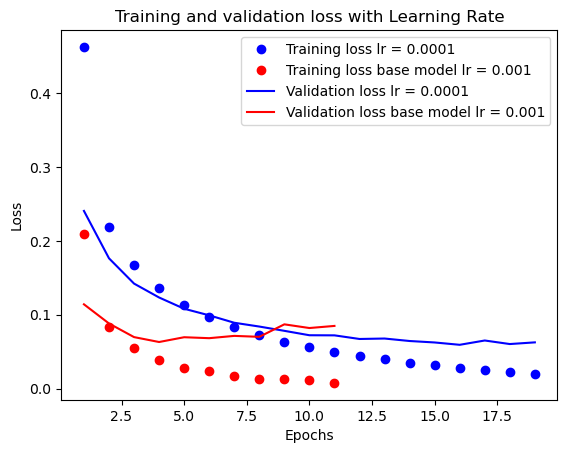

In [166]:
acc = history_lr_pt0001.history['accuracy']
val_acc = history_lr_pt0001.history['val_accuracy']
loss = history_lr_pt0001.history['loss']
val_loss = history_lr_pt0001.history['val_loss']

acc_2 = history.history['accuracy']
val_acc_2 = history.history['val_accuracy']
loss_2 = history.history['loss']
val_loss_2 = history.history['val_loss']

epochs = range(1, len(acc) + 1)
epochs_2 = range(1, len(acc_2) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss lr = 0.0001')
plt.plot(epochs_2, loss_2, 'ro', label='Training loss base model lr = 0.001')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss lr = 0.0001')
plt.plot(epochs_2, val_loss_2, 'r', label='Validation loss base model lr = 0.001')
plt.title('Training and validation loss with Learning Rate')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

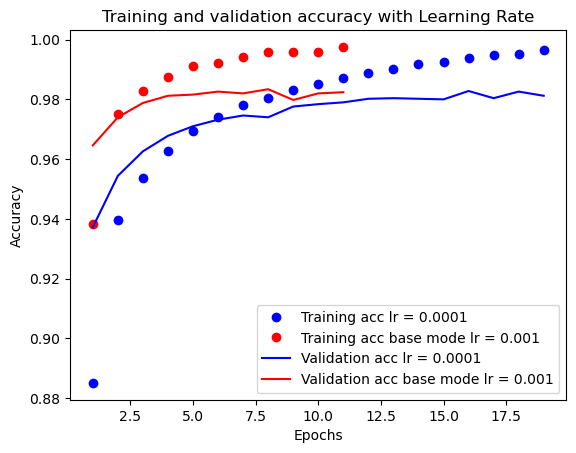

In [167]:
plt.clf()   # clear figure
acc_values = history_dict_lr_pt0001['accuracy']
acc_values_2 = history_dict['accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc lr = 0.0001')
plt.plot(epochs_2, acc_2, 'ro', label='Training acc base mode lr = 0.001')
plt.plot(epochs, val_acc, 'b', label='Validation acc lr = 0.0001')
plt.plot(epochs_2, val_acc_2, 'r', label='Validation acc base mode lr = 0.001')
plt.title('Training and validation accuracy with Learning Rate')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

___
# Experiment 9
Here we'll look at the impact of adjusting the activation function in the hidden layer. This will look at how using 'tanh' or 'sigmoid' differs from the base model that uses 'relu' in the hidden layer.
___
### Building and Timing the Base Model

In [168]:
start_time = time.time()
model = Sequential([
    Dense(input_shape=(28*28,), units=512, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
history = model.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
end_time_relu = time.time()
print(end_time_relu - start_time)

Epoch 1/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2086 - accuracy: 0.9385 - val_loss: 0.1108 - val_accuracy: 0.9654
Epoch 2/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0838 - accuracy: 0.9749 - val_loss: 0.0861 - val_accuracy: 0.9752
Epoch 3/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0545 - accuracy: 0.9834 - val_loss: 0.0744 - val_accuracy: 0.9758
Epoch 4/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0373 - accuracy: 0.9881 - val_loss: 0.0754 - val_accuracy: 0.9772
Epoch 5/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0273 - accuracy: 0.9910 - val_loss: 0.0706 - val_accuracy: 0.9812
Epoch 6/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0222 - accuracy: 0.9925 - val_loss: 0.0666 - val_accuracy: 0.9832
Epoch 7/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0164 - accuracy: 0.9945 - val_loss: 0.0770 - val_ac

### Testing Different Activation Functions

In [169]:
start_time = time.time()
model_tanh = Sequential([
    Dense(input_shape=(28*28,), units=512, activation=tf.nn.tanh),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

model_tanh.compile(tf.keras.optimizers.Adam(),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

history_tanh = model_tanh.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
end_time_tanh = time.time()
print(end_time_tanh - start_time)

Epoch 1/200
1719/1719 [==============================] - 5s 2ms/step - loss: 0.2843 - accuracy: 0.9158 - val_loss: 0.1693 - val_accuracy: 0.9516
Epoch 2/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1319 - accuracy: 0.9604 - val_loss: 0.1158 - val_accuracy: 0.9656
Epoch 3/200
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0834 - accuracy: 0.9746 - val_loss: 0.0803 - val_accuracy: 0.9752
Epoch 4/200
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0575 - accuracy: 0.9823 - val_loss: 0.0799 - val_accuracy: 0.9768
Epoch 5/200
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0409 - accuracy: 0.9869 - val_loss: 0.0752 - val_accuracy: 0.9780
Epoch 6/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0293 - accuracy: 0.9906 - val_loss: 0.0780 - val_accuracy: 0.9792
Epoch 7/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0208 - accuracy: 0.9938 - val_loss: 0.0720 - val_ac

In [170]:
start_time = time.time()
model_sigmoid = Sequential([
    Dense(input_shape=(28*28,), units=512, activation=tf.nn.sigmoid),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])
model_sigmoid.compile(tf.keras.optimizers.Adam(),
               loss='categorical_crossentropy',
               metrics=['accuracy'])
history_sigmoid = model_sigmoid.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
end_time_sigmoid = time.time()
print(end_time_sigmoid - start_time)

Epoch 1/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3506 - accuracy: 0.9005 - val_loss: 0.2072 - val_accuracy: 0.9414
Epoch 2/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1822 - accuracy: 0.9458 - val_loss: 0.1434 - val_accuracy: 0.9570
Epoch 3/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1207 - accuracy: 0.9639 - val_loss: 0.1029 - val_accuracy: 0.9704
Epoch 4/200
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0853 - accuracy: 0.9742 - val_loss: 0.0879 - val_accuracy: 0.9750
Epoch 5/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0625 - accuracy: 0.9816 - val_loss: 0.0784 - val_accuracy: 0.9754
Epoch 6/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0473 - accuracy: 0.9858 - val_loss: 0.0689 - val_accuracy: 0.9782
Epoch 7/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0347 - accuracy: 0.9899 - val_loss: 0.0677 - val_ac

In [171]:
test_loss_tanh, test_acc_tanh = model_tanh.evaluate(test_images, test_labels)
print(f'test acc using tanh: {test_acc_tanh}, test loss using tanh: {test_loss_tanh}')
test_loss_sigmoid, test_acc_sigmoid = model_sigmoid.evaluate(test_images, test_labels)
print(f'test acc using sigmoid: {test_acc_sigmoid}, test loss using sigmoid: {test_loss_sigmoid}')

313/313 [==============================] - 0s 1ms/step - loss: 0.0753 - accuracy: 0.9796
test acc using tanh: 0.9796000123023987, test loss using tanh: 0.07527491450309753
313/313 [==============================] - 0s 1ms/step - loss: 0.0727 - accuracy: 0.9795
test acc using sigmoid: 0.9794999957084656, test loss using sigmoid: 0.0727214440703392


### Plot Performance

In [172]:
history_dict_sigmoid = history_sigmoid.history
history_dict_sigmoid.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

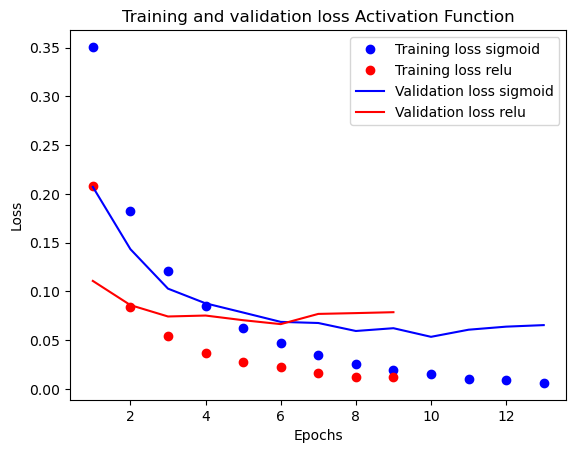

In [173]:
acc = history_sigmoid.history['accuracy']
val_acc = history_sigmoid.history['val_accuracy']
loss = history_sigmoid.history['loss']
val_loss = history_sigmoid.history['val_loss']

acc_2 = history.history['accuracy']
val_acc_2 = history.history['val_accuracy']
loss_2 = history.history['loss']
val_loss_2 = history.history['val_loss']

epochs = range(1, len(acc) + 1)
epochs_2 = range(1, len(acc_2) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss sigmoid')
plt.plot(epochs_2, loss_2, 'ro', label='Training loss relu')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss sigmoid')
plt.plot(epochs_2, val_loss_2, 'r', label='Validation loss relu')
plt.title('Training and validation loss Activation Function')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

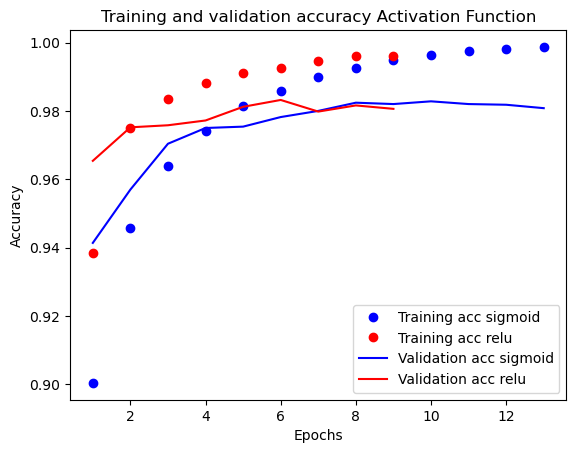

In [174]:
plt.clf()   # clear figure
acc_values = history_dict_sigmoid['accuracy']
acc_values_2 = history_dict['accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc sigmoid')
plt.plot(epochs_2, acc_2, 'ro', label='Training acc relu')
plt.plot(epochs, val_acc, 'b', label='Validation acc sigmoid')
plt.plot(epochs_2, val_acc_2, 'r', label='Validation acc relu')
plt.title('Training and validation accuracy Activation Function')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

___
# Experiment 10
In this final experiment we'll look at the impact of adjusting the optimizer to 'RMSprop' or 'SGD' from the base model that uses 'adam'.
___
### Testing Different Optimizers

In [175]:
model_rmsprop = Sequential([
    Dense(input_shape=(28*28,), units=512, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

model_SGD = Sequential([
    Dense(input_shape=(28*28,), units=512, activation=tf.nn.relu),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])

In [176]:
model_rmsprop.compile(tf.keras.optimizers.RMSprop(),
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model_SGD.compile(tf.keras.optimizers.SGD(),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [177]:
history_rmsprop = model_rmsprop.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
history_SGD = model_SGD.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )

Epoch 1/200
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2135 - accuracy: 0.9365 - val_loss: 0.1028 - val_accuracy: 0.9700
Epoch 2/200
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0947 - accuracy: 0.9727 - val_loss: 0.0973 - val_accuracy: 0.9718
Epoch 3/200
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0678 - accuracy: 0.9808 - val_loss: 0.0740 - val_accuracy: 0.9792
Epoch 4/200
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0508 - accuracy: 0.9855 - val_loss: 0.0792 - val_accuracy: 0.9786
Epoch 5/200
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0411 - accuracy: 0.9887 - val_loss: 0.0949 - val_accuracy: 0.9774
Epoch 6/200
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0332 - accuracy: 0.9912 - val_loss: 0.0889 - val_accuracy: 0.9792
Epoch 1/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6357 - accuracy: 0.8455 - val_loss: 0.3527 - val_ac

In [178]:
test_loss_rmsprop, test_acc_rmsprop = model_rmsprop.evaluate(test_images, test_labels)
print(f'test acc using RMSprop optimizer: {test_acc_rmsprop}, test loss using RMSprop optimizer: {test_loss_rmsprop}')
test_loss_SGD, test_acc_SGD = model_SGD.evaluate(test_images, test_labels)
print(f'test acc using SGD optimizer: {test_acc_SGD}, test loss using SGD optimizer: {test_loss_SGD}')

313/313 [==============================] - 0s 1ms/step - loss: 0.0912 - accuracy: 0.9804
test acc using RMSprop optimizer: 0.980400025844574, test loss using RMSprop optimizer: 0.09120867401361465
313/313 [==============================] - 0s 1ms/step - loss: 0.0883 - accuracy: 0.9742
test acc using SGD optimizer: 0.9742000102996826, test loss using SGD optimizer: 0.08833467215299606


### Plot Performance

In [179]:
history_dict_rmsprop = history_rmsprop.history
history_dict_rmsprop.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

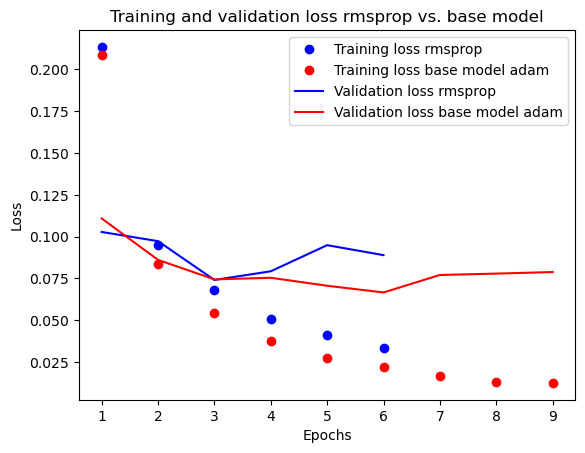

In [180]:
acc = history_rmsprop.history['accuracy']
val_acc = history_rmsprop.history['val_accuracy']
loss = history_rmsprop.history['loss']
val_loss = history_rmsprop.history['val_loss']

acc_2 = history.history['accuracy']
val_acc_2 = history.history['val_accuracy']
loss_2 = history.history['loss']
val_loss_2 = history.history['val_loss']

epochs = range(1, len(acc) + 1)
epochs_2 = range(1, len(acc_2) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss rmsprop')
plt.plot(epochs_2, loss_2, 'ro', label='Training loss base model adam')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss rmsprop')
plt.plot(epochs_2, val_loss_2, 'r', label='Validation loss base model adam')
plt.title('Training and validation loss rmsprop vs. base model')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

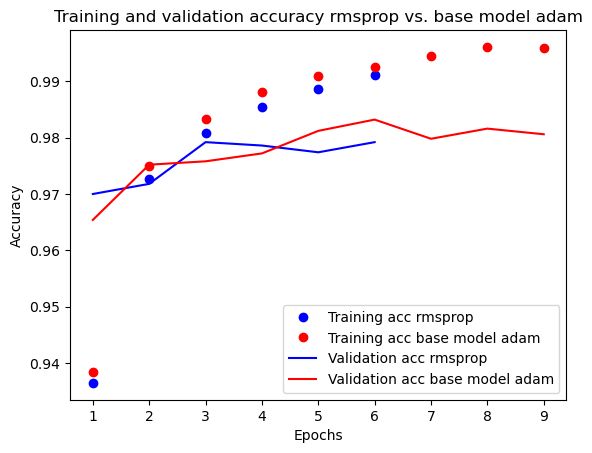

In [181]:
plt.clf()   # clear figure
acc_values = history_dict_rmsprop['accuracy']
acc_values_2 = history_dict['accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc rmsprop')
plt.plot(epochs_2, acc_2, 'ro', label='Training acc base model adam')
plt.plot(epochs, val_acc, 'b', label='Validation acc rmsprop')
plt.plot(epochs_2, val_acc_2, 'r', label='Validation acc base model adam')
plt.title('Training and validation accuracy rmsprop vs. base model adam')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Compare Final Results

In [182]:
exp = ["1: Single Neuron", "2: Two Neurons", "3: Explore Neuron/Layer Variations", "3: Explore Neuron/Layer Variations",
      "3: Explore Neuron/Layer Variations", "3: Explore Neuron/Layer Variations", "3: Explore Neuron/Layer Variations", 
      "3: Explore Neuron/Layer Variations", "3: Explore Neuron/Layer Variations", "3: Explore Neuron/Layer Variations", 
      "3: Explore Neuron/Layer Variations", "3: Explore Neuron/Layer Variations", "3: Explore Neuron/Layer Variations", 
      "3: Explore Neuron/Layer Variations", "4: PCA Decomposition", "5: Random Forest", "6: Weight Regularizer", 
      "6: Weight Regularizer", "6: Weight Regularizer", "7: Add Dropout", "7: Add Dropout", "7: Add Dropout",
      "8: Adjust Learning Rates", "8: Adjust Learning Rates", "8: Adjust Learning Rates", "9: Activation Functions",
      "9: Activation Functions", "10: Optimizers", "10: Optimizers"]

mod_neurons = [1, 2, 16, 32, 64, 128, 256, 512, 16, 32, 64, 128, 256, 512, 512, 512, 512, 512, 512,
              512, 512, 512, 512, 512, 512, 512, 512, 512, 512]

mod_layers = [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

mod_adj = ["one neuron", "two Neurons", "1 layer, 16 neurons", "1 layer, 32 neurons", "1 layer, 64 neurons",
           "1 layer, 128 neurons", "1 layer, 256 neurons", "1 layer, 512 neurons", "2 layers, 16 neurons",
           "2 layers, 32 neurons", "2 layers, 64 neurons", "2 layers, 128 neurons", "2 layers, 256 neurons",
           "2 layers, 512 neurons", "PCA 784 dim to 154", "RF top 70 features", "L1/L2 reg. = 0.01", 
           "L1/L2 reg. = 0.001", "L1/L2 reg. = 0.0001", "Dropout = 0.3", "Dropout = 0.4", "Dropout = 0.5",
           "Learning rate = 0.05", "Learning rate = 0.0001", "Learning rate = 0.00001",
           "Activation Function = tanh", "Activation Function = sigmoid", "Optimizer = RMSProp", "Optimizer = SGD"]

mod_loss = [test_loss_1, test_loss_2, test_loss_1_16, test_loss_1_32, test_loss_1_64, test_loss_1_128, test_loss_1_256,
           test_loss_1_512, test_loss_2_16, test_loss_2_32, test_loss_2_64, test_loss_2_128, test_loss_2_256,
           test_loss_2_512, test_loss_pca, test_loss_rf, test_loss_l1_l2_01, test_loss_l1_l2_001, test_loss_l1_l2_0001,
           test_loss_dropout_3, test_loss_dropout_4, test_loss_dropout_5, test_loss_lr_pt05, test_loss_lr_pt0001,
           test_loss_lr_pt00001, test_loss_tanh, test_loss_sigmoid, test_loss_rmsprop, test_loss_SGD]

mod_acc = [test_acc_1, test_acc_2, test_acc_1_16, test_acc_1_32, test_acc_1_64, test_acc_1_128, test_acc_1_256,
            test_acc_1_512, test_acc_2_16, test_acc_2_32, test_acc_2_64, test_acc_2_128, test_acc_2_256, test_acc_2_512,
            test_acc_pca, test_acc_rf, test_acc_l1_l2_01, test_acc_l1_l2_001, test_acc_l1_l2_0001,
            test_acc_dropout_3, test_acc_dropout_4, test_acc_dropout_5, test_acc_lr_pt05, test_acc_lr_pt0001,
            test_acc_lr_pt00001, test_acc_tanh, test_acc_sigmoid, test_acc_rmsprop, test_acc_SGD]

results_df = pd.DataFrame({'Experiment': exp,
                          'Model # Neurons':mod_neurons,
                          'Model # Layers':mod_layers,
                          'Model Adjustments':mod_adj,
                          'Test Accuracy': np.round(mod_acc, 3),
                          'Test Loss': np.round(mod_loss, 3)})

In [183]:
#https://stackoverflow.com/questions/50100635/highlight-color-a-panda-data-frame-row-by-index
results_df.style.apply(lambda x: ['background: yellow'
                                 if x.name in [7]
                                 else '' for i in x], axis=1)

,Experiment,Model # Neurons,Model # Layers,Model Adjustments,Test Accuracy,Test Loss
0,1: Single Neuron,1,1,one neuron,0.364000,1.570000
1,2: Two Neurons,2,1,two Neurons,0.661000,0.984000
2,3: Explore Neuron/Layer Variations,16,1,"1 layer, 16 neurons",0.953000,0.168000
3,3: Explore Neuron/Layer Variations,32,1,"1 layer, 32 neurons",0.969000,0.110000
4,3: Explore Neuron/Layer Variations,64,1,"1 layer, 64 neurons",0.974000,0.096000
5,3: Explore Neuron/Layer Variations,128,1,"1 layer, 128 neurons",0.977000,0.087000
6,3: Explore Neuron/Layer Variations,256,1,"1 layer, 256 neurons",0.976000,0.080000
7,3: Explore Neuron/Layer Variations,512,1,"1 layer, 512 neurons",0.982000,0.102000
8,3: Explore Neuron/Layer Variations,16,2,"2 layers, 16 neurons",0.956000,0.154000
9,3: Explore Neuron/Layer Variations,32,2,"2 layers, 32 neurons",0.970000,0.106000


### Final Model

In [184]:
start_time = time.time()
model_a = Sequential([
    Dense(input_shape=(28*28,), units=512, activation=tf.nn.relu),
    Dropout(0.5),
    Dense(name = "output_layer", units=10, activation=tf.nn.softmax)
])
model_a.compile(tf.keras.optimizers.Adam(learning_rate = 0.0005),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
history_a = model_a.fit(train_images,
                     train_labels,
                     epochs=200,
                     validation_data=(val_images, val_labels),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
                     )
end_time_relu = time.time()
print(end_time_relu - start_time)

test_loss_a, test_acc_a = model_a.evaluate(test_images, test_labels)
print(f'test acc: {test_acc_a}, test loss: {test_loss_a}')

Epoch 1/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3323 - accuracy: 0.9043 - val_loss: 0.1488 - val_accuracy: 0.9604
Epoch 2/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1591 - accuracy: 0.9538 - val_loss: 0.1032 - val_accuracy: 0.9726
Epoch 3/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1180 - accuracy: 0.9652 - val_loss: 0.0812 - val_accuracy: 0.9756
Epoch 4/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0951 - accuracy: 0.9705 - val_loss: 0.0754 - val_accuracy: 0.9778
Epoch 5/200
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0796 - accuracy: 0.9755 - val_loss: 0.0717 - val_accuracy: 0.9782
Epoch 6/200
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0704 - accuracy: 0.9775 - val_loss: 0.0610 - val_accuracy: 0.9808
Epoch 7/200
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0631 - accuracy: 0.9799 - val_loss: 0.0647 - val_ac

In [185]:
history_dict_a = history_a.history
history_dict_a.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

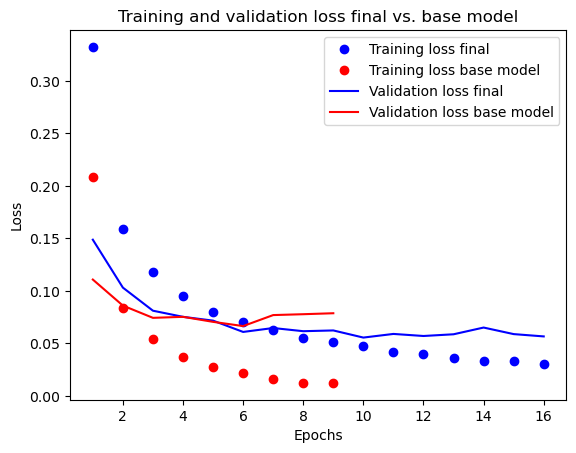

In [186]:
acc = history_a.history['accuracy']
val_acc = history_a.history['val_accuracy']
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']

acc_2 = history.history['accuracy']
val_acc_2 = history.history['val_accuracy']
loss_2 = history.history['loss']
val_loss_2 = history.history['val_loss']

epochs = range(1, len(acc) + 1)
epochs_2 = range(1, len(acc_2) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss final')
plt.plot(epochs_2, loss_2, 'ro', label='Training loss base model')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss final')
plt.plot(epochs_2, val_loss_2, 'r', label='Validation loss base model')
plt.title('Training and validation loss final vs. base model')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

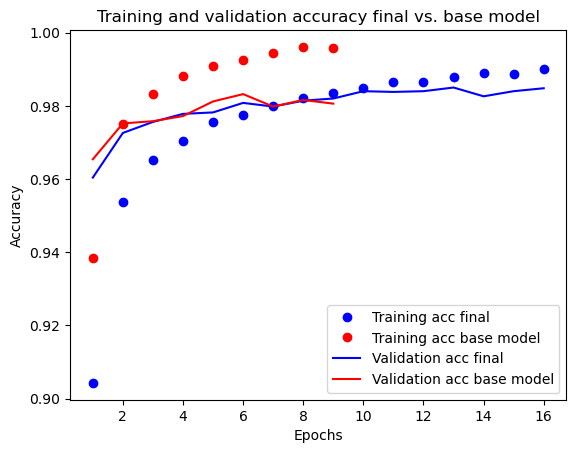

In [187]:
plt.clf()   # clear figure
acc_values = history_dict_a['accuracy']
acc_values_2 = history_dict['accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc final')
plt.plot(epochs_2, acc_2, 'ro', label='Training acc base model')
plt.plot(epochs, val_acc, 'b', label='Validation acc final')
plt.plot(epochs_2, val_acc_2, 'r', label='Validation acc base model')
plt.title('Training and validation accuracy final vs. base model')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()